In [2]:
import os
import re
import time
import pickle
import mglearn
import string
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from IPython.display import display

from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import TweetTokenizer
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import make_scorer, confusion_matrix

%matplotlib inline
sns.set(font_scale=1.25)
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)
pd.options.display.max_columns = 0
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', -1)

In [2]:
tokenizer = nltk.casual.TweetTokenizer(strip_handles=True, preserve_case=True, reduce_len=True)

class NLTKPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, stopwords=None, punct=None,
                 lower=True, strip=True):
        self.lower      = lower
        self.strip      = strip
        self.stopwords  = stopwords or set(sw.words('english'))
        self.punct      = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]

    def transform(self, X):
        return [list(self.tokenize(doc)) for doc in X]
    
    def tokenize(self, document):
        tknzr = TweetTokenizer(strip_handles=True)
        for token in tknzr.tokenize(document):
        #for token, tag in pos_tag(tknzr.tokenize(document)):
            token = token.lower() if self.lower else token
            token = token.strip() if self.strip else token
            token = token.strip('_') if self.strip else token
            token = token.strip('*') if self.strip else token
            if token in self.stopwords:
                continue
            if all(char in self.punct for char in token):
                continue
            yield token
#            lemma = self.lemmatize(token, tag)
#            yield lemma
 
    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)
        return self.lemmatizer.lemmatize(token, tag)

def identity(arg):
    return arg

### Prepare Population Dataframe (Without Training Sample) for SML Classifiers

Load the population dataframe without the training sample and add columns of a) tweet text without URLs and b) tweet text with usernames and user descriptions.

**Note**: Do not run this again, as the final result has been saved in an HD5 file and the training sample has been added back to it.

In [5]:
filtered_tweets = os.path.expanduser('~/Dropbox/University of Oxford/Oxford Internet Institute/Dissertation/Data/tweets_processed_filtered_with_dvs_without_test.h5')
hdf = pd.HDFStore(filtered_tweets)
df = hdf["tweets"]
df.head()

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,rt_count,like_count,rt_count_binary,like_count_binary
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4543,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/s4SOtpA8ya],1,1,[animated_gif],0,0,1,13.00,32.00,1,1
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4545,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/8Tf8FDVUnh],1,1,[animated_gif],0,0,1,8.00,29.00,1,1
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3442,5,"[voteleave, eureferendum, euref, remain]",4,[],0,[https://t.co/OiGzHH50f6],1,1,[pic.twitter.com/xRPciOzi6Z],1,1,[photo],1,0,0,0.00,nan,0,0
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3443,5,"[brexit, remain, eureferendum]",3,[],0,[https://t.co/0pSeyDUbNm],1,1,[],0,0,[],0,0,0,0.00,nan,0,0
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Friday,05:07:06,05,Small hours,69,0.06,Tweet Jukebox,None,None,https://www.twitter.com/RemainShame/status/720825751310716930,Do you want live in EU dictatorship? https://t.co/A2E0AHAZpj #EUreferendum #Brexit #Remain #strongerin #INcampaign https://t.co/N4fL7ko0ye,BrexitNeverSurrender,RemainShame,The Spirit of a Great Man Lives On,False,74,60,2016-03-22,"Kent, England",NaN,715,20,"[eureferendum, brexit, remain, strongerin, incampaign]",5,[],0,[https://t.co/A2E0AHAZpj],1,1,[pic.twitter.com/N4fL7ko0ye],1,1,[photo],1,0,0,0.00,nan,0,0


In [6]:
df.insert(14, 'text_no_urls', df.text.map(lambda x: re.sub(r"http\S+", "", x)))
df.insert(15, 'text_username_description', df['text_no_urls'] + " " + df['user_name'] + " " + df['user_screen_name'] + " " + df['user_description'].fillna(''))
df

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,text_no_urls,text_username_description,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,rt_count,like_count,rt_count_binary,like_count_binary
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,The best couple 4Ever 💟 💟 #Britin #QAF,"The best couple 4Ever 💟 💟 #Britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4543,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/s4SOtpA8ya],1,1,[animated_gif],0,0,1,13.00,32.00,1,1
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF,"AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4545,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/8Tf8FDVUnh],1,1,[animated_gif],0,0,1,8.00,29.00,1,1
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,#VoteLeave and Austerity Will End #eureferendum #euref #Remain,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3442,5,"[voteleave, eureferendum, euref, remain]",4,[],0,[https://t.co/OiGzHH50f6],1,1,[pic.twitter.com/xRPciOzi6Z],1,1,[photo],1,0,0,0.00,nan,0,0
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3443,5,"[brexit, remain, eureferendum]",3,[],0,[https://t.co/0pSeyDUbNm],1,1,[],0,0,[],0,0,0,0.00,nan,0,0
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Friday,05:07:06,05,Small hours,69,0.06,Tweet Jukebox,None,None,https://www.twitter.com/RemainShame/status/720825751310716930,Do you want live in EU dictatorship? https://t.co/A2E0AHAZpj #EUreferendum #Brexit #Remain #strongerin #INcampaign https://t.co/N4fL7ko0ye,Do you want live in EU dictatorship? #EUreferendum #Brexit #Remain #strongerin #INcampaign,Do you want live in EU dictatorship? #EUreferendu

### Load Classifiers and Label Tweet Text

**Position**

In [7]:
position_classifier = open('gs_clf_svc_position_trained.pickle', 'rb') 
clf_svc_position = pickle.load(position_classifier)
position_classifier.close()
clf_svc_position

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip..., max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))])

In [8]:
df['position'] = clf_svc_position.predict(df.text_username_description)
df.position = df.position.astype('object')
df.head()

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,text_no_urls,text_username_description,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,rt_count,like_count,rt_count_binary,like_count_binary,position
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,The best couple 4Ever 💟 💟 #Britin #QAF,"The best couple 4Ever 💟 💟 #Britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4543,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/s4SOtpA8ya],1,1,[animated_gif],0,0,1,13.00,32.00,1,1,Remain
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF,"AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4545,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/8Tf8FDVUnh],1,1,[animated_gif],0,0,1,8.00,29.00,1,1,Leave
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,#VoteLeave and Austerity Will End #eureferendum #euref #Remain,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3442,5,"[voteleave, eureferendum, euref, remain]",4,[],0,[https://t.co/OiGzHH50f6],1,1,[pic.twitter.com/xRPciOzi6Z],1,1,[photo],1,0,0,0.00,nan,0,0,Leave
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3443,5,"[brexit, remain, eureferendum]",3,[],0,[https://t.co/0pSeyDUbNm],1,1,[],0,0,[],0,0,0,0.00,nan,0,0,Leave
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Friday,05:07:06,05,Small hours,69,0.06,Tweet Jukebox,None,None,https://www.twitter.com/RemainShame/status/720825751310716930,Do you want live in EU dictatorship? https://t.co/A2E0AHAZpj #EUreferendum #Brexit #Remain #strongerin #INcampaign https://t.co/N4fL7ko0ye,Do you want live in EU dictatorship? #EUreferendum #Brexit #Remain #strongerin #INcampaign,Do you want liv

**Message Type**

Need to create a new column combining tweet text (without URLs) and predicted position in order to predict message type.

In [9]:
df.insert(16, 'text_and_position', df['text_no_urls'] + " " + df['position'])
df.head()

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,text_no_urls,text_username_description,text_and_position,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,rt_count,like_count,rt_count_binary,like_count_binary,position
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,The best couple 4Ever 💟 💟 #Britin #QAF,"The best couple 4Ever 💟 💟 #Britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",The best couple 4Ever 💟 💟 #Britin #QAF Remain,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4543,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/s4SOtpA8ya],1,1,[animated_gif],0,0,1,13.00,32.00,1,1,Remain
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF,"AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Leave,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4545,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/8Tf8FDVUnh],1,1,[animated_gif],0,0,1,8.00,29.00,1,1,Leave
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,#VoteLeave and Austerity Will End #eureferendum #euref #Remain,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3442,5,"[voteleave, eureferendum, euref, remain]",4,[],0,[https://t.co/OiGzHH50f6],1,1,[pic.twitter.com/xRPciOzi6Z],1,1,[photo],1,0,0,0.00,nan,0,0,Leave
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3443,5,"[brexit, remain, eureferendum]",3,[],0,[https://t.co/0pSeyDUbNm],1,1,[],0,0,[],0,0,0,0.00,nan,0,0,Leave
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Friday,05:07:06,05,Small hours,69,0.06,Tweet Jukebox,None,None,https://www.twitter.com/RemainSham

In [11]:
message_type_classifier = open('gs_clf_svc_message_type_trained.pickle', 'rb') 
clf_svc_message_type = pickle.load(message_type_classifier)
message_type_classifier.close()
clf_svc_message_type

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip..., max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0))])

In [12]:
df['message_type'] = clf_svc_message_type.predict(df.text_and_position)
df.message_type = df.message_type.astype('object')
df.head()

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,text_no_urls,text_username_description,text_and_position,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,rt_count,like_count,rt_count_binary,like_count_binary,position,message_type
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,The best couple 4Ever 💟 💟 #Britin #QAF,"The best couple 4Ever 💟 💟 #Britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",The best couple 4Ever 💟 💟 #Britin #QAF Remain,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4543,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/s4SOtpA8ya],1,1,[animated_gif],0,0,1,13.00,32.00,1,1,Remain,Division
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF,"AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Leave,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4545,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/8Tf8FDVUnh],1,1,[animated_gif],0,0,1,8.00,29.00,1,1,Leave,Division
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,#VoteLeave and Austerity Will End #eureferendum #euref #Remain,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3442,5,"[voteleave, eureferendum, euref, remain]",4,[],0,[https://t.co/OiGzHH50f6],1,1,[pic.twitter.com/xRPciOzi6Z],1,1,[photo],1,0,0,0.00,nan,0,0,Leave,Division
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3443,5,"[brexit, remain, eureferendum]",3,[],0,[https://t.co/0pSeyDUbNm],1,1,[],0,0,[],0,0,0,0.00,nan,0,0,Leave,Other
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Friday,05:07:06,05,Small hours,69,0.06,Tweet Jukebo

**Issue**

In [17]:
issue_classifier = open('clf_ve_issue_binary_trained.pickle', 'rb') 
clf_ve_issue = pickle.load(issue_classifier)
issue_classifier.close()
clf_ve_issue

VotingClassifier(estimators=[('nb', Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), pre...      presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False))]))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [18]:
df['issue'] = clf_ve_issue.predict(df.text_no_urls)
df.issue = df.issue.astype('object')
df.head()

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,text_no_urls,text_username_description,text_and_position,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,rt_count,like_count,rt_count_binary,like_count_binary,position,message_type,issue
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,The best couple 4Ever 💟 💟 #Britin #QAF,"The best couple 4Ever 💟 💟 #Britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",The best couple 4Ever 💟 💟 #Britin #QAF Remain,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4543,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/s4SOtpA8ya],1,1,[animated_gif],0,0,1,13.00,32.00,1,1,Remain,Division,0
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF,"AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Leave,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4545,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/8Tf8FDVUnh],1,1,[animated_gif],0,0,1,8.00,29.00,1,1,Leave,Division,0
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,#VoteLeave and Austerity Will End #eureferendum #euref #Remain,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3442,5,"[voteleave, eureferendum, euref, remain]",4,[],0,[https://t.co/OiGzHH50f6],1,1,[pic.twitter.com/xRPciOzi6Z],1,1,[photo],1,0,0,0.00,nan,0,0,Leave,Division,1
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3443,5,"[brexit, remain, eureferendum]",3,[],0,[https://t.co/0pSeyDUbNm],1,1,[],0,0,[],0,0,0,0.00,nan,0,0,Leave,Other,0
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Friday,05:07:06,05,Small hours,69,0.0

**Emotion**

In [21]:
emotion_classifier = open('clf_ve_emotion_binary_trained.pickle', 'rb') 
clf_ve_emotion = pickle.load(emotion_classifier)
emotion_classifier.close()
clf_ve_emotion

VotingClassifier(estimators=[('nb', Pipeline(memory=None,
     steps=[('vect', NLTKPreprocessor(lower=True,
         punct={'/', '.', '`', ')', '"', '&', '{', '}', '=', ']', '#', '@', '\\', '_', '|', ';', ':', '~', '>', '(', '[', '%', ',', '+', '!', '-', '<', "'", '^', '*', '$', '?'},
         stopwords={'yourselves...ty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [22]:
df['emotion'] = clf_ve_emotion.predict(df.text_no_urls)
df.emotion = df.emotion.astype('object')
df.head()

C:\Users\Periwynkle\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,text_no_urls,text_username_description,text_and_position,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,rt_count,like_count,rt_count_binary,like_count_binary,position,message_type,issue,emotion
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,The best couple 4Ever 💟 💟 #Britin #QAF,"The best couple 4Ever 💟 💟 #Britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",The best couple 4Ever 💟 💟 #Britin #QAF Remain,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4543,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/s4SOtpA8ya],1,1,[animated_gif],0,0,1,13.00,32.00,1,1,Remain,Division,0,1
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF,"AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Leave,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4545,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/8Tf8FDVUnh],1,1,[animated_gif],0,0,1,8.00,29.00,1,1,Leave,Division,0,1
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,#VoteLeave and Austerity Will End #eureferendum #euref #Remain,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3442,5,"[voteleave, eureferendum, euref, remain]",4,[],0,[https://t.co/OiGzHH50f6],1,1,[pic.twitter.com/xRPciOzi6Z],1,1,[photo],1,0,0,0.00,nan,0,0,Leave,Division,1,1
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3443,5,"[brexit, remain, eureferendum]",3,[],0,[https://t.co/0pSeyDUbNm],1,1,[],0,0,[],0,0,0,0.00,nan,0,0,Leave,Other,0,0
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Friday,05:07:06,05,Sm

**Resolution**

In [24]:
resolution_classifier = open('gs_clf_nb_resolution_trained.pickle', 'rb') 
clf_nb_resolution = pickle.load(resolution_classifier)
resolution_classifier.close()
clf_nb_resolution

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

In [25]:
df['resolution'] = clf_nb_resolution.predict(df.text_no_urls)
df.resolution = df.resolution.astype('object')
df.head()

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,text_no_urls,text_username_description,text_and_position,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,rt_count,like_count,rt_count_binary,like_count_binary,position,message_type,issue,emotion,resolution
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,The best couple 4Ever 💟 💟 #Britin #QAF,"The best couple 4Ever 💟 💟 #Britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",The best couple 4Ever 💟 💟 #Britin #QAF Remain,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4543,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/s4SOtpA8ya],1,1,[animated_gif],0,0,1,13.00,32.00,1,1,Remain,Division,0,1,0
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF,"AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Leave,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4545,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/8Tf8FDVUnh],1,1,[animated_gif],0,0,1,8.00,29.00,1,1,Leave,Division,0,1,0
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,#VoteLeave and Austerity Will End #eureferendum #euref #Remain,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3442,5,"[voteleave, eureferendum, euref, remain]",4,[],0,[https://t.co/OiGzHH50f6],1,1,[pic.twitter.com/xRPciOzi6Z],1,1,[photo],1,0,0,0.00,nan,0,0,Leave,Division,1,1,0
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3443,5,"[brexit, remain, eureferendum]",3,[],0,[https://t.co/0pSeyDUbNm],1,1,[],0,0,[],0,0,0,0.00,nan,0,0,Leave,Other,0,0,0
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Fr

### Use Dictionary Approaches to Label Question and Organisation

**Question**

In [27]:
df['question'] = np.where(df.text.str.contains('\?'), 1, 0)
df.question = df.question.astype('object')
df.head()

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,text_no_urls,text_username_description,text_and_position,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,rt_count,like_count,rt_count_binary,like_count_binary,position,message_type,issue,emotion,resolution,question
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,The best couple 4Ever 💟 💟 #Britin #QAF,"The best couple 4Ever 💟 💟 #Britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",The best couple 4Ever 💟 💟 #Britin #QAF Remain,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4543,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/s4SOtpA8ya],1,1,[animated_gif],0,0,1,13.00,32.00,1,1,Remain,Division,0,1,0,0
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF,"AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Leave,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4545,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/8Tf8FDVUnh],1,1,[animated_gif],0,0,1,8.00,29.00,1,1,Leave,Division,0,1,0,0
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,#VoteLeave and Austerity Will End #eureferendum #euref #Remain,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3442,5,"[voteleave, eureferendum, euref, remain]",4,[],0,[https://t.co/OiGzHH50f6],1,1,[pic.twitter.com/xRPciOzi6Z],1,1,[photo],1,0,0,0.00,nan,0,0,Leave,Division,1,1,0,0
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3443,5,"[brexit, remain, eureferendum]",3,[],0,[https://t.co/0pSeyDUbNm],1,1,[],0,0,[],0,0,0,0.00,nan,0,0,Leave,Other,0,0,0,0
720825751310716930,2016-04-15 05:07:0

**Organisation**

In [45]:
organisations = []

with open("organisations.txt", "r") as f:
    organisations = [l[:-1] for l in f.readlines()] #Each line in the .text file ends with /n (new line), so have to cut off the last two characters with [:-1].

print("First 10 organisations:", organisations[:10])
print("Total number of organisations:", len(organisations))

First 10 organisations: ['Adecco_UK', 'Another_Europe', 'Arron_banks', 'Avaaz', 'BBCBreaking', 'BBCNews', 'BBCRealityCheck', 'BNE_Group', 'BeLeaveBritain', 'BeLeaveUK']
Total number of organisations: 173


Add manually labelled organisations from the random sample to the list of organisations.

In [5]:
sample_tweets = os.path.expanduser('~/Dropbox/University of Oxford/Oxford Internet Institute/Dissertation/Data/4000_sample_v5.csv')
sample_df = pd.read_csv(sample_tweets)
sample_df.set_index('tweet_id', inplace=True)
sample_df = sample_df.rename(columns={'institution': 'organisation'})
sample_df.head()

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,position,organisation,message_type,message_format,question,enthusiasm,anxiety,aversion,resolution,playfulness,issue,notes,rt_count_api,like_count_api,rt_count,like_count,rt_count_binary,like_count_binary
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
735586419721293824,2016-05-25 22:40:43,2016-05-25,2,Wednesday,22:40:43,23,Night,29.00,7.03,Twitter for iPhone,nan,NaN,https://www.twitter.com/SAYNO2EU/status/735586419721293824,"Young people of these Beautiful British Islands, please make sure you're registered to vote in the #EUreferendum #VoteLEAVE",#VoteLeaveEU,SAYNO2EU,Britain is STRONGER OUT of the EU #VoteLeave #BREXIT,False,14358.00,7327.00,2009-05-17,NaN,Casablanca,95.00,53.00,"['eureferendum', 'voteleave']",2.00,[],0.00,[],0.00,0,[],0.00,0,[],0,0,0,Leave,0,Identification,0,0,1,0,0,1,0,None,Page doesn't exist.,nan,nan,1.00,0.00,1,0
741004645431189504,2016-06-09 21:30:49,2016-06-09,3,Thursday,21:30:49,22,Night,14.00,6.82,Twitter for iPhone,nan,NaN,https://www.twitter.com/BenMacpherson/status/741004645431189504,".@NicolaSturgeon - in an interdependent world, independent countries should work together for the common good. #ITVEURef #EUref #VoteRemain",Ben Macpherson MSP,BenMacpherson,Local MSP for Edinburgh Northern & Leith (@theSNP). Passionate about justice & progress. Scot & internationalist. Email: ben.macpherson.msp@parliament.scot.,False,2350.00,2106.00,2009-08-13,"Edinburgh, Scotland",Edinburgh,2332.00,938.00,"['itveuref', 'euref', 'voteremain']",3.00,['NicolaSturgeon'],1.00,[],0.00,0,[],0.00,0,[],0,0,0,Remain,1,Identification,1,0,1,0,0,0,0,Security,User is an MSP - Member of the Scottish Parliament.,17.00,15.00,17.00,13.00,1,1
729211671613452288,2016-05-08 08:29:45,2016-05-08,6,Sunday,08:29:45,8,Morning,46.00,0.18,Twitter for iPhone,nan,NaN,https://www.twitter.com/confEUsedbrit/status/729211671613452288,We #VoteLeave to finally stop the EU taking the piss out of us. We know we're not #StrongerIn. We know Dave doesn't care about the people.,Stronger Out,confEUsedbrit,"Standing up for British people and British democracy. 323,000 immigrants per year + £350m paid to the EU per week + zero democracy = #voteleave",False,159.00,66.00,2016-03-04,NaN,NaN,1394.00,152.00,"['voteleave', 'strongerin']",2.00,[],0.00,[],0.00,0,[],0.00,0,[],0,0,0,Leave,0,Division,0,0,0,0,1,0,0,Other,Issue concerns the EU at large but the phrase 'taking the piss' is too broad to fit into a specific category.,16.00,7.00,17.00,8.00,1,1
741007887103864833,2016-06-09 21:43:42,2016-06-09,3,Thursday,21:43:42,22,Night,14.00,6.41,Twitter for Android,nan,NaN,https://www.twitter.com/ScottPCarlton/status/741007887103864833,According to Angela Eagle we are not in the EU. Serious gaff. Up their with Gordon Brown's we saved the world comment. #VoteLeave,Scott Carlton,ScottPCarlton,NaN,False,129.00,592.00,2010-01-14,"Newton, Nottinghamshire",NaN,369.00,86.00,['voteleave'],1.00,[],0.00,[],0.00,0,[],0.00,0,[],0,0,0,Leave,0,Division,0,0,0,0,1,0,0,Other,References broad points made by Labour politicians; no specific issue is pinpointed.,0.00,0.00,0.00,nan,0,0
745519782330413056,2016-06-22 08:32:21,2016-06-22,2,Wednesday,08:32:21,9,Morning,1.00,6.04,Twitter for iPhone,nan,NaN,https://www.twitter.com/Enid_The_Cat/status/745519782330413056,I've watched the TV debates and would like to remain in the EU #CatsAgainstBrexit #kittensagainstbrexit https://t.co/cEXHAerPcc,Enid The Cat,Enid_The_Cat,NaN,False,6.00,8.00,2010-06-10,NaN,NaN,6.00,6.00,"['catsagainstbrexit', 'kittensagainstbre

In [12]:
sample_organisations = sample_df[sample_df.organisation == 1]
sample_organisations

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,position,organisation,message_type,message_format,question,enthusiasm,anxiety,aversion,resolution,playfulness,issue,notes,rt_count_api,like_count_api,rt_count,like_count,rt_count_binary,like_count_binary
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
741004645431189504,2016-06-09 21:30:49,2016-06-09,3,Thursday,21:30:49,22,Night,14.00,6.82,Twitter for iPhone,nan,NaN,https://www.twitter.com/BenMacpherson/status/741004645431189504,".@NicolaSturgeon - in an interdependent world, independent countries should work together for the common good. #ITVEURef #EUref #VoteRemain",Ben Macpherson MSP,BenMacpherson,Local MSP for Edinburgh Northern & Leith (@theSNP). Passionate about justice & progress. Scot & internationalist. Email: ben.macpherson.msp@parliament.scot.,False,2350.00,2106.00,2009-08-13,"Edinburgh, Scotland",Edinburgh,2332.00,938.00,"['itveuref', 'euref', 'voteremain']",3.00,['NicolaSturgeon'],1.00,[],0.00,0,[],0.00,0,[],0,0,0,Remain,1,Identification,1,0,1,0,0,0,0,Security,User is an MSP - Member of the Scottish Parliament.,17.00,15.00,17.00,13.00,1,1
745637986558222336,2016-06-22 16:22:03,2016-06-22,2,Wednesday,16:22:03,16,Afternoon,1.00,8.22,TweetDeck,nan,NaN,https://www.twitter.com/UKLabour/status/745637986558222336,"We can protect jobs, defend workers' rights & safeguard our NHS if we Remain, says @jeremycorbyn #LabourInForBritain https://t.co/Nl40YvYvn3",The Labour Party,UKLabour,"Twitter feed of the UK Labour Party, keeping you up-to-date with news, speeches, events & videos.",True,325178.00,15011.00,2008-04-03,NaN,London,18214.00,124.00,['labourinforbritain'],1.00,['jeremycorbyn'],1.00,[],0.00,0,['pic.twitter.com/Nl40YvYvn3'],1.00,1,['photo'],1,0,0,Remain,1,Identification,1,0,1,0,0,0,0,Economy and labour,Healthcare is a sub-theme.,117.00,99.00,127.00,101.00,1,1
740215529231798272,2016-06-07 17:15:09,2016-06-07,1,Tuesday,17:15:09,17,Afternoon,16.00,3.85,Twitter Web Client,nan,NaN,https://www.twitter.com/juliansmithmp/status/740215529231798272,"226,000 people registered to vote yesterday. Make sure you are one of them and get your say! #StrongerIN #EURef #HaveYourSay",Julian Smith MP,juliansmithmp,MP for Skipton & Ripon & Government Whip. For casework enquiries julian.smith.mp@parliament.uk or call 0207 219 7145. http://www.facebook.com/juliansmithmp,True,6225.00,2832.00,2012-07-31,NaN,London,5682.00,1493.00,"['strongerin', 'euref', 'haveyoursay']",3.00,[],0.00,[],0.00,0,[],0.00,0,[],0,0,0,Remain,1,Other,0,0,1,0,0,1,0,None,NaN,3.00,2.00,4.00,2.00,1,1
738093075843678208,2016-06-01 20:41:17,2016-06-01,2,Wednesday,20:41:17,21,Night,22.00,5.00,Twitter Web Client,nan,NaN,https://www.twitter.com/GreenKeithMEP/status/738093075843678208,Green MEPs secure parliamentary inquiry into #PanamaPapers https://t.co/8HriE63uWK & Osborne to be called https://t.co/u5YYxZ4xeU #GreenerIN,Keith Taylor MEP,GreenKeithMEP,"Green MEP for South East England. Animals spokesperson for the Green Party. Working for a fairer, greener future. Joined in EP by @GreenJeanMEP and @MollyMEP.",True,7600.00,730.00,2011-06-03,South East/Brussels,Pacific Time (US & Canada),2901.00,153.00,"['panamapapers', 'greenerin']",2.00,[],0.00,"['https://t.co/8HriE63uWK', 'https://t.co/u5YYxZ4xeU']",2.00,1,[],0.00,0,[],0,0,0,Remain,1,Other,0,0,1,0,0,0,0,Economy and labour,NaN,7.00,3.00,7.00,1.00,1,1
743328358893649924,2016-06-16 07:24:25,2016-06-16,3,Thursday,07:24:25,7,Morning,7.00,0.39,Twitter for Android,nan,NaN,https://www.twitter.com/WalesStrongerIn/status/743328358893649924,A v

In [21]:
sample_organisations_list = sample_organisations['user_screen_name'].tolist()
print(len(sample_organisations_list))
sample_organisations_set = set(sample_organisations_list)
print(len(sample_organisations_set))
sample_organisations_set

141
91


{'AEIfdp',
 'AdamCatterall',
 'Adamstoon1',
 'AlistairBurtMP',
 'AngelaRayner',
 'BenMacpherson',
 'BrandonLewis',
 'CPJElmore',
 'CaroleTongue',
 'CharlesTannock',
 'ChathamHouse',
 'ChukaUmunna',
 'ConservativesIN',
 'David_Cameron',
 'Debbie_abrahams',
 'DerekMackaySNP',
 'DianaJohnsonMP',
 'EUCouncilPress',
 'EUCouncilTVNews',
 'GMBYoungMembers',
 'Grahamhiscott',
 'GreenKeithMEP',
 'GregHands',
 'HJJoyceEcon',
 'HelenGoodmanMP',
 'HelenJonesMP',
 'HenrySmithMP',
 'JOE_co_uk',
 'KayBurley',
 'KellyTolhurst',
 'LSEGovernment',
 'Labour4NE',
 'LabourEquality',
 'LabourLordsUK',
 'LabourNorthWest',
 'LibDems',
 'LiberalYouth',
 'London_First',
 'LordJohnTaylor',
 'MPritchardMP',
 'MarcusFysh',
 'Nina_Trentmann',
 'OilSheppard',
 'PHammondMP',
 'PollstationUK',
 'RobertBuckland',
 'RyanCoetzee',
 'SDoughtyMP',
 'SMFthinktank',
 'SarahLudford',
 'Stop_The_EU',
 'StrongerIn',
 'StrongerInPress',
 'SuzanneEvans1',
 'TheBricsPost',
 'TheScepticIsle',
 'UKLabour',
 'UKLabourIN',
 'UKMoments

In [46]:
for user in sample_organisations_set:
    organisations.append(user)

len(organisations)

264

In [47]:
organisations = set(organisations)
len(organisations)

245

In [48]:
organisations

{'AEIfdp',
 'AdamCatterall',
 'Adamstoon1',
 'Adecco_UK',
 'AlistairBurtMP',
 'AngelaRayner',
 'Another_Europe',
 'Arron_banks',
 'Avaaz',
 'BBCBreaking',
 'BBCNews',
 'BBCRealityCheck',
 'BNE_Group',
 'BeLeaveBritain',
 'BeLeaveUK',
 'BenMacpherson',
 'BetterOffOut',
 'BloombergTV',
 'BorisJohnson',
 'Brand_EU',
 'BrandonLewis',
 'BrexitE',
 'BrexitTheMovie',
 'BrexitWatch',
 'BritInds4IN',
 'BrugesGroup',
 'Business4GO',
 'CAEFtweet',
 'CPJElmore',
 'CRAEDO',
 'CWUnews',
 'CamForEurope',
 'CaroleTongue',
 'CarolineLucas',
 'CharlesTannock',
 'ChathamHouse',
 'ChukaUmunna',
 'CityAM',
 'ClientEarth',
 'CommunityUnion',
 'ConnollyAssoc',
 'ConservativesIN',
 'DailyMailUK',
 'DailyMirror',
 'Daily_Express',
 'Daily_Star',
 'DanHannanMEP',
 'DanielJHannan',
 'David_Cameron',
 'Debbie_abrahams',
 'DemocracyMovemt',
 'DerekMackaySNP',
 'DianaJohnsonMP',
 'DouglasCarswell',
 'E3G',
 'EUCouncilPress',
 'EUCouncilTVNews',
 'EconForBrexit',
 'EveningStandard',
 'ExittheEU',
 'FT',
 'FedTrust',

In [50]:
default = df.user_screen_name.isin(organisations).values

MP = (((df.user_description.str.contains('MP', na=False)) # Not all MPs include 'MP' in their username.
     | df.user_name.str.contains('MP') 
     | df.user_screen_name.str.contains('MP')) 
     & (df.user_verified==True)) # Need to include this as there are many parody MP accounts, and almost all MP accounts are verified.
MP = MP.values

# Not all MEPs or MSPs are verified.
MEP = (df.user_name.str.contains('MEP') | df.user_screen_name.str.contains('MEP'))
MEP = MEP.values
MSP = (df.user_name.str.contains('MSP') | df.user_screen_name.str.contains('MSP'))
MSP = MSP.values

print(np.unique(default, return_counts=True))
print(np.unique(MP, return_counts=True))
print(np.unique(MEP, return_counts=True))
print(np.unique(MSP, return_counts=True))

(array([False,  True]), array([733766,  18730], dtype=int64))
(array([False,  True]), array([748229,   4267], dtype=int64))
(array([False,  True]), array([751306,   1190], dtype=int64))
(array([False,  True]), array([752394,    102], dtype=int64))


In [56]:
df['organisation'] = np.where((default | MP | MEP | MSP), 1, 0)
df.organisation = df.organisation.astype('object')
df.head()

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,position,organisation,message_type,question,emotion,resolution,issue,rt_count,like_count,rt_count_binary,like_count_binary,organisation1
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69.00,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057.00,206.00,2015-01-19,None,NaN,4543.00,2580.00,"[britin, qaf]",2.00,[],0.00,[],0.00,0,[pic.twitter.com/s4SOtpA8ya],1.00,1,[animated_gif],0,0,1,Remain,0,Division,0,1,0,0,13.00,32.00,1,1,0
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69.00,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057.00,206.00,2015-01-19,None,NaN,4545.00,2580.00,"[britin, qaf]",2.00,[],0.00,[],0.00,0,[pic.twitter.com/8Tf8FDVUnh],1.00,1,[animated_gif],0,0,1,Leave,0,Division,0,1,0,0,8.00,29.00,1,1,0
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69.00,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369.00,2821.00,2007-10-26,All major cities worldwide,London,3442.00,5.00,"[voteleave, eureferendum, euref, remain]",4.00,[],0.00,[https://t.co/OiGzHH50f6],1.00,1,[pic.twitter.com/xRPciOzi6Z],1.00,1,[photo],1,0,0,Leave,0,Division,0,1,0,1,0.00,nan,0,0,0
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69.00,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369.00,2821.00,2007-10-26,All major cities worldwide,London,3443.00,5.00,"[brexit, remain, eureferendum]",3.00,[],0.00,[https://t.co/0pSeyDUbNm],1.00,1,[],0.00,0,[],0,0,0,Leave,0,Other,0,0,0,0,0.00,nan,0,0,0
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Friday,05:07:06,05,Small hours,69.00,0.06,Tweet Jukebox,None,None,https://www.twitter.com/RemainShame/status/720825751310716930,Do you want live in EU dictatorship? https://t.co/A2E0AHAZpj #EUreferendum #Brexit #Remain #strongerin #INcampaign https://t.co/N4fL7ko0ye,BrexitNeverSurrender,RemainShame,The Spirit of a Great Man Lives On,False,74.00,60.00,2016-03-22,"Kent, England",NaN,715.00,20.00,"[eureferendum, brexit, remain, strongerin, incampaign]",5.00,[],0.00,[https://t.co/A2E0AHAZpj],1.00,1,[pic.twitter.com/N4fL7ko0ye],1.00,1,[photo],1,0,0,Leave,0,Division,1,1,0,1,0.00,nan,0,0,0


### Save Population Dataframe with SML-Classified IVs

In [65]:
def save_h5(obj, filename):
    store = pd.HDFStore(filename)
    store["tweets"] = obj
    store.close()

save_h5(df, "population_df_with_IVs.h5")

C:\Users\Periwynkle\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block2_values] [items->['created_at', 'date', 'day_numeric', 'day', 'time', 'hour', 'hour_binned', 'source', 'in_reply_to_user_id', 'coordinates', 'tweet_url', 'text', 'user_name', 'user_screen_name', 'user_description', 'user_created_at', 'user_location', 'user_time_zone', 'hashtags', 'mentions', 'urls', 'urls_count_binary', 'media_urls', 'media_type_count_binary', 'media_type', 'photo', 'video', 'gif', 'position', 'organisation', 'message_type', 'question', 'emotion', 'resolution', 'issue', 'rt_count_binary', 'like_count_binary']]



### Merge Population and Random Sample Dataframes

Load the population dataframe with IVs labelled by the SML classifiers from above. Drop columns added for classifiers: 'text_no_urls', 'text_username_description', 'text_and_position'. Reorder columns so that the IVs are before the DVs.

In [2]:
tweets_with_IVs = os.path.expanduser('~/Dropbox/University of Oxford/Oxford Internet Institute/Dissertation/Data/population_df_with_IVs.h5')
hdf = pd.HDFStore(tweets_with_IVs)
df = hdf["tweets"]
df

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,days_before_ref_log10,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,text_no_urls,text_username_description,text_and_position,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_followers_count_log10,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_statuses_count_log10,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,rt_count,like_count,rt_count_binary,like_count_binary,position,message_type,issue,emotion,resolution,question,organisation
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69,1.84,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,The best couple 4Ever 💟 💟 #Britin #QAF,"The best couple 4Ever 💟 💟 #Britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",The best couple 4Ever 💟 💟 #Britin #QAF Remain,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,3.02,206,2015-01-19,None,NaN,4543,3.66,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/s4SOtpA8ya],1,1,[animated_gif],0,0,1,13.00,32.00,1,1,Remain,Division,0,1,0,0,0
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69,1.84,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF,"AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Brian And Justin ❤ BritinQaf Argentina fans who love Brian and Justin , this twitter is dedicated to them",AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF Leave,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,3.02,206,2015-01-19,None,NaN,4545,3.66,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/8Tf8FDVUnh],1,1,[animated_gif],0,0,1,8.00,29.00,1,1,Leave,Division,0,1,0,0,0
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69,1.84,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,#VoteLeave and Austerity Will End #eureferendum #euref #Remain,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#VoteLeave and Austerity Will End #eureferendum #euref #Remain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,5.02,2821,2007-10-26,All major cities worldwide,London,3442,3.54,5,"[voteleave, eureferendum, euref, remain]",4,[],0,[https://t.co/OiGzHH50f6],1,1,[pic.twitter.com/xRPciOzi6Z],1,1,[photo],1,0,0,0.00,nan,0,0,Leave,Division,1,1,0,0,0
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69,1.84,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Daily Squib News DAILYSQUIB CAUTION! The Daily Squib can be hazardous to your health!,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain Leave,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,5.02,2821,2007-10-26,All major cities worldwide,London,3443,3.54,5,"[

In [ ]:
del df['text_no_urls']
del df['text_username_description']
del df['text_and_position']

In [8]:
print(df.shape)
print(list(df.columns))

(749520, 50)
['created_at', 'date', 'day_numeric', 'day', 'time', 'hour', 'hour_binned', 'days_before_ref', 'account_age', 'source', 'in_reply_to_user_id', 'coordinates', 'tweet_url', 'text', 'user_name', 'user_screen_name', 'user_description', 'user_verified', 'user_followers_count', 'user_friends_count', 'user_created_at', 'user_location', 'user_time_zone', 'user_statuses_count', 'user_favourites_count', 'hashtags', 'hashtags_count', 'mentions', 'mentions_count', 'urls', 'urls_count', 'urls_count_binary', 'media_urls', 'media_type_count', 'media_type_count_binary', 'media_type', 'photo', 'video', 'gif', 'rt_count', 'like_count', 'rt_count_binary', 'like_count_binary', 'position', 'message_type', 'issue', 'emotion', 'resolution', 'question', 'organisation']


In [18]:
cols = df.columns.tolist()
print(len(cols))
print(cols[:39])
print(cols[39:43])
print(cols[43:])
reordered_cols = cols[:39] + ['position', 'organisation', 'message_type', 'question', 'emotion', 'resolution', 'issue'] + cols[39:43]
print(reordered_cols)
len(reordered_cols)

50
['created_at', 'date', 'day_numeric', 'day', 'time', 'hour', 'hour_binned', 'days_before_ref', 'account_age', 'source', 'in_reply_to_user_id', 'coordinates', 'tweet_url', 'text', 'user_name', 'user_screen_name', 'user_description', 'user_verified', 'user_followers_count', 'user_friends_count', 'user_created_at', 'user_location', 'user_time_zone', 'user_statuses_count', 'user_favourites_count', 'hashtags', 'hashtags_count', 'mentions', 'mentions_count', 'urls', 'urls_count', 'urls_count_binary', 'media_urls', 'media_type_count', 'media_type_count_binary', 'media_type', 'photo', 'video', 'gif']
['rt_count', 'like_count', 'rt_count_binary', 'like_count_binary']
['position', 'message_type', 'issue', 'emotion', 'resolution', 'question', 'organisation']
['created_at', 'date', 'day_numeric', 'day', 'time', 'hour', 'hour_binned', 'days_before_ref', 'account_age', 'source', 'in_reply_to_user_id', 'coordinates', 'tweet_url', 'text', 'user_name', 'user_screen_name', 'user_description', 'user_v

50

In [19]:
df = df[reordered_cols]
df.head()

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,position,organisation,message_type,question,emotion,resolution,issue,rt_count,like_count,rt_count_binary,like_count_binary
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4543,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/s4SOtpA8ya],1,1,[animated_gif],0,0,1,Remain,0,Division,0,1,0,0,13.00,32.00,1,1
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057,206,2015-01-19,None,NaN,4545,2580,"[britin, qaf]",2,[],0,[],0,0,[pic.twitter.com/8Tf8FDVUnh],1,1,[animated_gif],0,0,1,Leave,0,Division,0,1,0,0,8.00,29.00,1,1
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3442,5,"[voteleave, eureferendum, euref, remain]",4,[],0,[https://t.co/OiGzHH50f6],1,1,[pic.twitter.com/xRPciOzi6Z],1,1,[photo],1,0,0,Leave,0,Division,0,1,0,1,0.00,nan,0,0
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369,2821,2007-10-26,All major cities worldwide,London,3443,5,"[brexit, remain, eureferendum]",3,[],0,[https://t.co/0pSeyDUbNm],1,1,[],0,0,[],0,0,0,Leave,0,Other,0,0,0,0,0.00,nan,0,0
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Friday,05:07:06,05,Small hours,69,0.06,Tweet Jukebox,None,None,https://www.twitter.com/RemainShame/status/720825751310716930,Do you want live in EU dictatorship? https://t.co/A2E0AHAZpj #EUreferendum #Brexit #Remain #strongerin #INcampaign https://t.co/N4fL7ko0ye,BrexitNeverSurrender,RemainShame,The Spirit of a Great Man Lives On,False,74,60,2016-03-22,"Kent, England",NaN,715,20,"[eureferendum, brexit, remain, strongerin, incampaign]",5,[],0,[https://t.co/A2E0AHAZpj],1,1,[pic.twitter.com/N4fL7ko0ye],1,1,[photo],1,0,0,Leave,0,Division,1,1,0,1,0.00,nan,0,0


Load the random sample used for SML classifier training and append to the population dataframe. Before merging:
- Rename 'institution' as 'organisation'.
- Create 'issue_binary' column.
- Create 'emotion' column: 1 if 'enthusiasm' or 'anxiety' or 'aversion' is 1, otherwise 0.
- Drop the following columns not present in the population dataframe: 'message_format',  'playfulness', 'issue' (multiclass version), 'notes', 'rt_count_api', 'like_count_api', 'enthusiasm', 'anxiety', 'aversion'.
- Rename 'issue_binary' as 'issue'.
- Change type of categorical variables with numeric categories to 'object'.

In [6]:
sample_tweets = os.path.expanduser('~/Dropbox/University of Oxford/Oxford Internet Institute/Dissertation/Data/4000_sample_v5.csv')
sample_df = pd.read_csv(sample_tweets)
sample_df.set_index('tweet_id', inplace=True)
sample_df = sample_df.rename(columns={'institution': 'organisation'})
print(sample_df.shape)
print(list(sample_df.columns))

(2976, 57)
['created_at', 'date', 'day_numeric', 'day', 'time', 'hour', 'hour_binned', 'days_before_ref', 'account_age', 'source', 'in_reply_to_user_id', 'coordinates', 'tweet_url', 'text', 'user_name', 'user_screen_name', 'user_description', 'user_verified', 'user_followers_count', 'user_friends_count', 'user_created_at', 'user_location', 'user_time_zone', 'user_statuses_count', 'user_favourites_count', 'hashtags', 'hashtags_count', 'mentions', 'mentions_count', 'urls', 'urls_count', 'urls_count_binary', 'media_urls', 'media_type_count', 'media_type_count_binary', 'media_type', 'photo', 'video', 'gif', 'position', 'organisation', 'message_type', 'message_format', 'question', 'enthusiasm', 'anxiety', 'aversion', 'resolution', 'playfulness', 'issue', 'notes', 'rt_count_api', 'like_count_api', 'rt_count', 'like_count', 'rt_count_binary', 'like_count_binary']


In [25]:
sample_df.insert(50, 'issue_binary', np.where(sample_df.issue != 'None', 1, 0))
sample_df.insert(44, 'emotion', np.where((sample_df.enthusiasm == 1) | (sample_df.anxiety == 1) | (sample_df.aversion == 1), 1, 0))
sample_df

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,position,organisation,message_type,message_format,question,emotion,enthusiasm,anxiety,aversion,resolution,playfulness,issue,issue_binary,notes,rt_count_api,like_count_api,rt_count,like_count,rt_count_binary,like_count_binary
tweet_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
735586419721293824,2016-05-25 22:40:43,2016-05-25,2,Wednesday,22:40:43,23,Night,29.00,7.03,Twitter for iPhone,nan,NaN,https://www.twitter.com/SAYNO2EU/status/735586419721293824,"Young people of these Beautiful British Islands, please make sure you're registered to vote in the #EUreferendum #VoteLEAVE",#VoteLeaveEU,SAYNO2EU,Britain is STRONGER OUT of the EU #VoteLeave #BREXIT,False,14358.00,7327.00,2009-05-17,NaN,Casablanca,95.00,53.00,"['eureferendum', 'voteleave']",2.00,[],0.00,[],0.00,0,[],0.00,0,[],0,0,0,Leave,0,Identification,0,0,1,1,0,0,1,0,None,0,Page doesn't exist.,nan,nan,1.00,0.00,1,0
741004645431189504,2016-06-09 21:30:49,2016-06-09,3,Thursday,21:30:49,22,Night,14.00,6.82,Twitter for iPhone,nan,NaN,https://www.twitter.com/BenMacpherson/status/741004645431189504,".@NicolaSturgeon - in an interdependent world, independent countries should work together for the common good. #ITVEURef #EUref #VoteRemain",Ben Macpherson MSP,BenMacpherson,Local MSP for Edinburgh Northern & Leith (@theSNP). Passionate about justice & progress. Scot & internationalist. Email: ben.macpherson.msp@parliament.scot.,False,2350.00,2106.00,2009-08-13,"Edinburgh, Scotland",Edinburgh,2332.00,938.00,"['itveuref', 'euref', 'voteremain']",3.00,['NicolaSturgeon'],1.00,[],0.00,0,[],0.00,0,[],0,0,0,Remain,1,Identification,1,0,1,1,0,0,0,0,Security,1,User is an MSP - Member of the Scottish Parliament.,17.00,15.00,17.00,13.00,1,1
729211671613452288,2016-05-08 08:29:45,2016-05-08,6,Sunday,08:29:45,8,Morning,46.00,0.18,Twitter for iPhone,nan,NaN,https://www.twitter.com/confEUsedbrit/status/729211671613452288,We #VoteLeave to finally stop the EU taking the piss out of us. We know we're not #StrongerIn. We know Dave doesn't care about the people.,Stronger Out,confEUsedbrit,"Standing up for British people and British democracy. 323,000 immigrants per year + £350m paid to the EU per week + zero democracy = #voteleave",False,159.00,66.00,2016-03-04,NaN,NaN,1394.00,152.00,"['voteleave', 'strongerin']",2.00,[],0.00,[],0.00,0,[],0.00,0,[],0,0,0,Leave,0,Division,0,0,1,0,0,1,0,0,Other,1,Issue concerns the EU at large but the phrase 'taking the piss' is too broad to fit into a specific category.,16.00,7.00,17.00,8.00,1,1
741007887103864833,2016-06-09 21:43:42,2016-06-09,3,Thursday,21:43:42,22,Night,14.00,6.41,Twitter for Android,nan,NaN,https://www.twitter.com/ScottPCarlton/status/741007887103864833,According to Angela Eagle we are not in the EU. Serious gaff. Up their with Gordon Brown's we saved the world comment. #VoteLeave,Scott Carlton,ScottPCarlton,NaN,False,129.00,592.00,2010-01-14,"Newton, Nottinghamshire",NaN,369.00,86.00,['voteleave'],1.00,[],0.00,[],0.00,0,[],0.00,0,[],0,0,0,Leave,0,Division,0,0,1,0,0,1,0,0,Other,1,References broad points made by Labour politicians; no specific issue is pinpointed.,0.00,0.00,0.00,nan,0,0
745519782330413056,2016-06-22 08:32:21,2016-06-22,2,Wednesday,08:32:21,9,Morning,1.00,6.04,Twitter for iPhone,nan,NaN,https://www.twitter.com/Enid_The_Cat/status/745519782330413056,I've watched the TV debates and would like to remain in the EU #CatsAgainstBrexit #kittensagainstbrexit https://t.co/cEXHAerPcc,Enid The Cat,Enid_The_Cat,NaN,False,6.00,8.00,2010-06-10,NaN,NaN,6.00,6.00,"[

In [26]:
to_delete = ['message_format', 'playfulness', 'issue', 'notes', 'rt_count_api', 'like_count_api', 'enthusiasm', 'anxiety', 'aversion']

for col in to_delete:
    del sample_df[col]

(2976, 50)
['created_at', 'date', 'day_numeric', 'day', 'time', 'hour', 'hour_binned', 'days_before_ref', 'account_age', 'source', 'in_reply_to_user_id', 'coordinates', 'tweet_url', 'text', 'user_name', 'user_screen_name', 'user_description', 'user_verified', 'user_followers_count', 'user_friends_count', 'user_created_at', 'user_location', 'user_time_zone', 'user_statuses_count', 'user_favourites_count', 'hashtags', 'hashtags_count', 'mentions', 'mentions_count', 'urls', 'urls_count', 'urls_count_binary', 'media_urls', 'media_type_count', 'media_type_count_binary', 'media_type', 'photo', 'video', 'gif', 'position', 'organisation', 'message_type', 'question', 'emotion', 'resolution', 'issue_binary', 'rt_count', 'like_count', 'rt_count_binary', 'like_count_binary']


In [27]:
sample_df = sample_df.rename(columns={'issue_binary': 'issue'})
print(sample_df.shape)
print(list(sample_df.columns))

(2976, 50)
['created_at', 'date', 'day_numeric', 'day', 'time', 'hour', 'hour_binned', 'days_before_ref', 'account_age', 'source', 'in_reply_to_user_id', 'coordinates', 'tweet_url', 'text', 'user_name', 'user_screen_name', 'user_description', 'user_verified', 'user_followers_count', 'user_friends_count', 'user_created_at', 'user_location', 'user_time_zone', 'user_statuses_count', 'user_favourites_count', 'hashtags', 'hashtags_count', 'mentions', 'mentions_count', 'urls', 'urls_count', 'urls_count_binary', 'media_urls', 'media_type_count', 'media_type_count_binary', 'media_type', 'photo', 'video', 'gif', 'position', 'organisation', 'message_type', 'question', 'emotion', 'resolution', 'issue', 'rt_count', 'like_count', 'rt_count_binary', 'like_count_binary']


In [39]:
sample_df.day_numeric = sample_df.day_numeric.astype('object')
sample_df.hour = sample_df.hour.astype('object')
sample_df.in_reply_to_user_id = sample_df.in_reply_to_user_id.astype('object')
sample_df.urls_count_binary = sample_df.urls_count_binary.astype('object')
sample_df.media_type_count_binary = sample_df.media_type_count_binary.astype('object')
sample_df.photo = sample_df.photo.astype('object')
sample_df.video = sample_df.video.astype('object')
sample_df.gif = sample_df.gif.astype('object')
sample_df.organisation = sample_df.organisation.astype('object')
sample_df.question = sample_df.question.astype('object')
sample_df.emotion = sample_df.emotion.astype('object')
sample_df.resolution = sample_df.resolution.astype('object')
sample_df.rt_count_binary = sample_df.rt_count_binary.astype('object')
sample_df.like_count_binary = sample_df.like_count_binary.astype('object')
sample_df.issue = sample_df.issue.astype('object')

sample_df.describe()

,days_before_ref,account_age,user_followers_count,user_friends_count,user_statuses_count,user_favourites_count,hashtags_count,mentions_count,urls_count,media_type_count,rt_count,like_count
count,2976.00,2976.00,2976.00,2976.00,2976.00,2976.00,2976.00,2976.00,2976.00,2976.00,2976.00,1170.00
mean,17.16,3.87,4241.88,1614.52,46894.30,4194.52,2.52,0.28,0.33,0.24,6.79,20.66
std,17.05,2.58,31861.62,6035.54,204915.72,10528.38,1.64,0.64,0.48,0.48,162.17,461.56
min,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,1.28,120.00,179.00,1087.00,64.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,12.00,4.22,508.00,557.50,4622.00,534.00,2.00,0.00,0.00,0.00,0.00,1.00
75%,26.00,6.07,1894.00,1695.50,17378.50,3143.50,3.00,0.00,1.00,0.00,2.00,5.00
max,69.00,9.54,1480967.00,237253.00,2253139.00,139410.00,13.00,6.00,3.00,4.00,8796.00,15774.00


In [40]:
df = df.append(sample_df)
df

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,position,organisation,message_type,question,emotion,resolution,issue,rt_count,like_count,rt_count_binary,like_count_binary
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69.00,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057.00,206.00,2015-01-19,None,NaN,4543.00,2580.00,"[britin, qaf]",2.00,[],0.00,[],0.00,0,[pic.twitter.com/s4SOtpA8ya],1.00,1,[animated_gif],0,0,1,Remain,0,Division,0,1,0,0,13.00,32.00,1,1
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69.00,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057.00,206.00,2015-01-19,None,NaN,4545.00,2580.00,"[britin, qaf]",2.00,[],0.00,[],0.00,0,[pic.twitter.com/8Tf8FDVUnh],1.00,1,[animated_gif],0,0,1,Leave,0,Division,0,1,0,0,8.00,29.00,1,1
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69.00,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369.00,2821.00,2007-10-26,All major cities worldwide,London,3442.00,5.00,"[voteleave, eureferendum, euref, remain]",4.00,[],0.00,[https://t.co/OiGzHH50f6],1.00,1,[pic.twitter.com/xRPciOzi6Z],1.00,1,[photo],1,0,0,Leave,0,Division,0,1,0,1,0.00,nan,0,0
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69.00,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369.00,2821.00,2007-10-26,All major cities worldwide,London,3443.00,5.00,"[brexit, remain, eureferendum]",3.00,[],0.00,[https://t.co/0pSeyDUbNm],1.00,1,[],0.00,0,[],0,0,0,Leave,0,Other,0,0,0,0,0.00,nan,0,0
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Friday,05:07:06,05,Small hours,69.00,0.06,Tweet Jukebox,None,None,https://www.twitter.com/RemainShame/status/720825751310716930,Do you want live in EU dictatorship? https://t.co/A2E0AHAZpj #EUreferendum #Brexit #Remain #strongerin #INcampaign https://t.co/N4fL7ko0ye,BrexitNeverSurrender,RemainShame,The Spirit of a Great Man Lives On,False,74.00,60.00,2016-03-22,"Kent, England",NaN,715.00,20.00,"[eureferendum, brexit, remain, strongerin, incampaign]",5.00,[],0.00,[https://t.co/A2E0AHAZpj],1.00,1,[pic.twitter.com/N4fL7ko0ye],1.00,1,[photo],1,0,0,Leave,0,Division,1,1,0,1,0.00,nan,0,0
720825780058521600,2016-04-15 05:07:12,2016-04-15,4,Friday,05:07:12,05,Small hours,69.00,0.03,Tweet Jukebox,None,None,https://www.twitter.com/EU_Failed/status/720825780058521600,Selling Britain Off On the Cheap is Good Says #EU https://t.co/iXoWvXz3ok #eureferendum #euref #brexit #VOTELEAVE https://t.co/zgVlzxXdSa,EUfailed,EU_Failed,None,False,26.00,20.00,2016-04-02,None,NaN,78.00,1.00,"[eu, eureferendum, euref, brexit, vote

As the merge created a clash of hour notations ('0' and '00', '1' and '01', etc.), the hour column was regenerated.

In [17]:
df['created_at'] = pd.to_datetime(df['created_at'])
df.hour = df.created_at.dt.round('60min')
df.hour = df.hour.dt.strftime('%H')
print(set(df.hour.tolist()))

{'00', '09', '02', '08', '03', '07', '05', '04', '23', '18', '17', '22', '12', '19', '13', '20', '11', '06', '14', '21', '01', '10', '15', '16'}


In [3]:
print(df.shape)
print(list(df.columns))
df.describe()

(741411, 50)
['created_at', 'date', 'day_numeric', 'day', 'time', 'hour', 'hour_binned', 'days_before_ref', 'account_age', 'source', 'in_reply_to_user_id', 'coordinates', 'tweet_url', 'text', 'user_name', 'user_screen_name', 'user_description', 'user_verified', 'user_followers_count', 'user_friends_count', 'user_created_at', 'user_location', 'user_time_zone', 'user_statuses_count', 'user_favourites_count', 'hashtags', 'hashtags_count', 'mentions', 'mentions_count', 'urls', 'urls_count', 'urls_count_binary', 'media_urls', 'media_type_count', 'media_type_count_binary', 'media_type', 'photo', 'video', 'gif', 'position', 'organisation', 'message_type', 'question', 'emotion', 'resolution', 'issue', 'rt_count', 'like_count', 'rt_count_binary', 'like_count_binary']


,days_before_ref,account_age,user_followers_count,user_friends_count,user_statuses_count,user_favourites_count,hashtags_count,mentions_count,urls_count,media_type_count,rt_count,like_count
count,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,741411.00,278143.00
mean,17.68,3.90,4600.39,1535.25,40639.45,3890.77,2.56,0.29,0.35,0.25,4.22,9.01
std,17.17,2.59,74662.67,6392.37,180207.83,10332.97,1.72,0.66,0.48,0.51,48.03,86.64
min,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,1.33,110.00,160.00,1038.00,59.00,1.00,0.00,0.00,0.00,0.00,0.00
50%,13.00,4.25,471.00,533.00,4525.00,521.00,2.00,0.00,0.00,0.00,0.00,1.00
75%,27.00,6.13,1778.00,1593.00,16257.00,2882.00,3.00,0.00,1.00,0.00,1.00,5.00
max,69.00,9.95,22752666.00,1568791.00,6206247.00,390609.00,21.00,10.00,4.00,4.00,14258.00,18107.00


Save merged dataframe as an HD5 file (full population with IVs). Regenerate all frequencies from above.

In [22]:
def save_h5(obj, filename):
    store = pd.HDFStore(filename)
    store["tweets"] = obj
    store.close()

save_h5(df, "full_population_df_with_IVs.h5")

C:\Users\Periwynkle\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->['date', 'day_numeric', 'day', 'time', 'hour', 'hour_binned', 'source', 'in_reply_to_user_id', 'coordinates', 'tweet_url', 'text', 'user_name', 'user_screen_name', 'user_description', 'user_created_at', 'user_location', 'user_time_zone', 'hashtags', 'mentions', 'urls', 'urls_count_binary', 'media_urls', 'media_type_count_binary', 'media_type', 'photo', 'video', 'gif', 'position', 'organisation', 'message_type', 'question', 'emotion', 'resolution', 'issue', 'rt_count_binary', 'like_count_binary']]



### Visualise Variable Frequencies for Full Population

In [3]:
tweets_with_IVs = os.path.expanduser('~/Dropbox/University of Oxford/Oxford Internet Institute/Dissertation/Data/full_population_df_with_IVs.h5')
hdf = pd.HDFStore(tweets_with_IVs)
df = hdf["tweets"]
df

,created_at,date,day_numeric,day,time,hour,hour_binned,days_before_ref,account_age,source,in_reply_to_user_id,coordinates,tweet_url,text,user_name,user_screen_name,user_description,user_verified,user_followers_count,user_friends_count,user_created_at,user_location,user_time_zone,user_statuses_count,user_favourites_count,hashtags,hashtags_count,mentions,mentions_count,urls,urls_count,urls_count_binary,media_urls,media_type_count,media_type_count_binary,media_type,photo,video,gif,position,organisation,message_type,question,emotion,resolution,issue,rt_count,like_count,rt_count_binary,like_count_binary
720824890891218946,2016-04-15 05:03:40,2016-04-15,4,Friday,05:03:40,05,Small hours,69.00,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720824890891218946,The best couple 4Ever 💟 💟 #Britin #QAF https://t.co/s4SOtpA8ya,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057.00,206.00,2015-01-19,None,NaN,4543.00,2580.00,"[britin, qaf]",2.00,[],0.00,[],0.00,0,[pic.twitter.com/s4SOtpA8ya],1.00,1,[animated_gif],0,0,1,Remain,0,Division,0,1,0,0,13.00,32.00,1,1
720825272447021057,2016-04-15 05:05:11,2016-04-15,4,Friday,05:05:11,05,Small hours,69.00,1.24,Twitter for Android,None,None,https://www.twitter.com/BritinQaf/status/720825272447021057,AND WATCHING YOU WALK AWAY 💟 💟 💟 ❤ 💕 #britin #QAF https://t.co/8Tf8FDVUnh,Brian And Justin ❤,BritinQaf,"Argentina fans who love Brian and Justin , this twitter is dedicated to them",False,1057.00,206.00,2015-01-19,None,NaN,4545.00,2580.00,"[britin, qaf]",2.00,[],0.00,[],0.00,0,[pic.twitter.com/8Tf8FDVUnh],1.00,1,[animated_gif],0,0,1,Leave,0,Division,0,1,0,0,8.00,29.00,1,1
720825677277061120,2016-04-15 05:06:48,2016-04-15,4,Friday,05:06:48,05,Small hours,69.00,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825677277061120,#VoteLeave and Austerity Will End https://t.co/OiGzHH50f6 #eureferendum #euref #Remain https://t.co/xRPciOzi6Z,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369.00,2821.00,2007-10-26,All major cities worldwide,London,3442.00,5.00,"[voteleave, eureferendum, euref, remain]",4.00,[],0.00,[https://t.co/OiGzHH50f6],1.00,1,[pic.twitter.com/xRPciOzi6Z],1.00,1,[photo],1,0,0,Leave,0,Division,0,1,0,1,0.00,nan,0,0
720825685481119744,2016-04-15 05:06:50,2016-04-15,4,Friday,05:06:50,05,Small hours,69.00,8.47,Tweet Jukebox,None,None,https://www.twitter.com/DAILYSQUIB/status/720825685481119744,#Brexit #Remain #eureferendum BREXIT: Volcanoes and Lava Would Engulf Britain https://t.co/0pSeyDUbNm,Daily Squib News,DAILYSQUIB,CAUTION! The Daily Squib can be hazardous to your health!,False,104369.00,2821.00,2007-10-26,All major cities worldwide,London,3443.00,5.00,"[brexit, remain, eureferendum]",3.00,[],0.00,[https://t.co/0pSeyDUbNm],1.00,1,[],0.00,0,[],0,0,0,Leave,0,Other,0,0,0,0,0.00,nan,0,0
720825751310716930,2016-04-15 05:07:06,2016-04-15,4,Friday,05:07:06,05,Small hours,69.00,0.06,Tweet Jukebox,None,None,https://www.twitter.com/RemainShame/status/720825751310716930,Do you want live in EU dictatorship? https://t.co/A2E0AHAZpj #EUreferendum #Brexit #Remain #strongerin #INcampaign https://t.co/N4fL7ko0ye,BrexitNeverSurrender,RemainShame,The Spirit of a Great Man Lives On,False,74.00,60.00,2016-03-22,"Kent, England",NaN,715.00,20.00,"[eureferendum, brexit, remain, strongerin, incampaign]",5.00,[],0.00,[https://t.co/A2E0AHAZpj],1.00,1,[pic.twitter.com/N4fL7ko0ye],1.00,1,[photo],1,0,0,Leave,0,Division,1,1,0,1,0.00,nan,0,0
720825780058521600,2016-04-15 05:07:12,2016-04-15,4,Friday,05:07:12,05,Small hours,69.00,0.03,Tweet Jukebox,None,None,https://www.twitter.com/EU_Failed/status/720825780058521600,Selling Britain Off On the Cheap is Good Says #EU https://t.co/iXoWvXz3ok #eureferendum #euref #brexit #VOTELEAVE https://t.co/zgVlzxXdSa,EUfailed,EU_Failed,None,False,26.00,20.00,2016-04-02,None,NaN,78.00,1.00,"[eu, eureferendum, euref, brexit, vote

position
Ambiguous    41469 
Leave        396870
Remain       303072
Name: text, dtype: int64


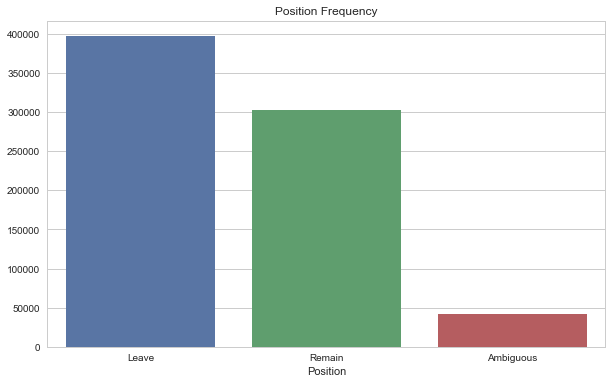

In [4]:
print(df.groupby('position').text.count())
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='position', order=['Leave', 'Remain', 'Ambiguous']).plot(figsize=(10,6))
plt.title('Position Frequency')
plt.ylabel('')
plt.xlabel('Position')
fig.savefig('Position Frequency.jpg', bbox_inches='tight')

message_type
Division          521446
Identification    120223
Other             99742 
Name: text, dtype: int64


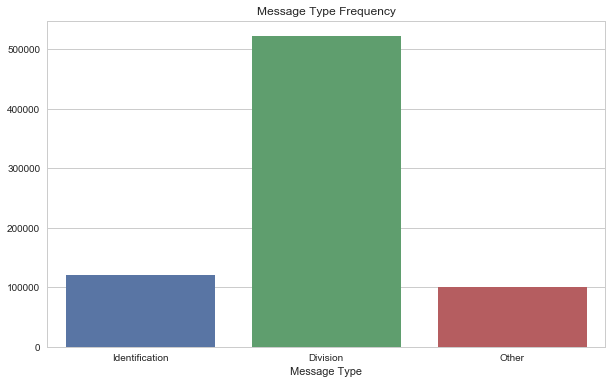

In [5]:
print(df.groupby('message_type').text.count())
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='message_type', order=['Identification', 'Division', 'Other']).plot(figsize=(10,6))
plt.title('Message Type Frequency')
plt.ylabel('')
plt.xlabel('Message Type')
fig.savefig('Message Type Frequency.jpg', bbox_inches='tight')

issue
0    369903
1    371508
Name: text, dtype: int64


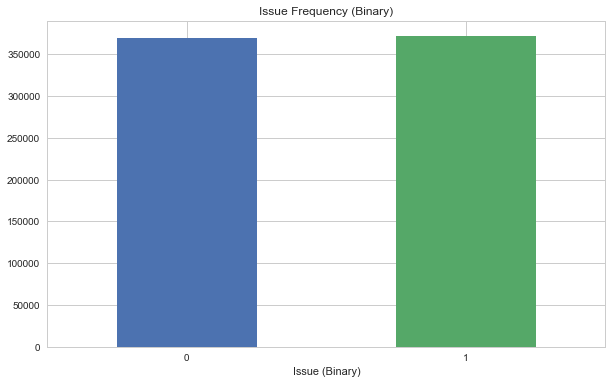

In [6]:
print(df.groupby('issue').text.count())
fig = plt.figure(figsize=(10,6))
df.groupby('issue').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.xlabel('Issue (Binary)')
plt.title('Issue Frequency (Binary)')
plt.show()
fig.savefig('Issue Frequency (Binary).jpg', bbox_inches='tight')

emotion
0    100310
1    641101
Name: text, dtype: int64


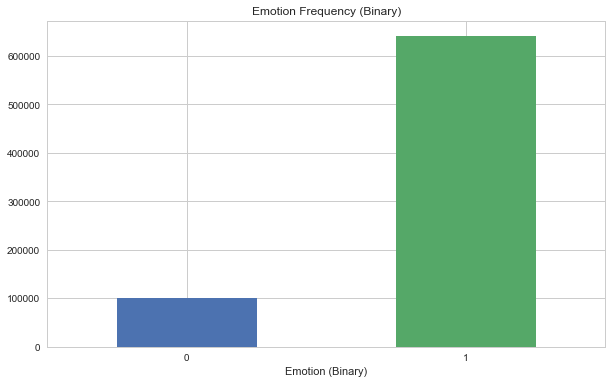

In [7]:
print(df.groupby('emotion').text.count())
fig = plt.figure(figsize=(10,6))
df.groupby('emotion').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.xlabel('Emotion (Binary)')
plt.title('Emotion Frequency (Binary)')
plt.show()
fig.savefig('Emotion Frequency (Binary).jpg', bbox_inches='tight')

resolution
0    710281
1    31130 
Name: text, dtype: int64


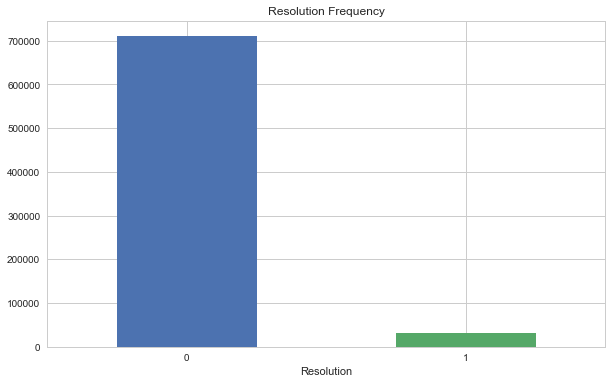

In [8]:
print(df.groupby('resolution').text.count())
fig = plt.figure(figsize=(10,6))
df.groupby('resolution').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.xlabel('Resolution')
plt.title('Resolution Frequency')
plt.show()
fig.savefig('Resolution Frequency.jpg', bbox_inches='tight')

question
0    648750
1    92661 
Name: text, dtype: int64


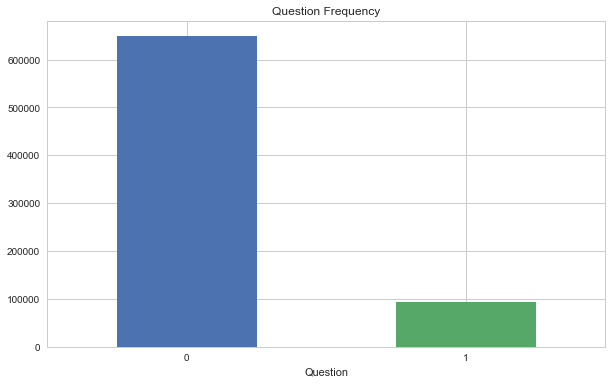

In [9]:
print(df.groupby('question').text.count())
fig = plt.figure(figsize=(10,6))
df.groupby('question').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.xlabel('Question')
plt.title('Question Frequency')
plt.show()
fig.savefig('Question Frequency.jpg', bbox_inches='tight')

organisation
0    718479
1    22932 
Name: text, dtype: int64


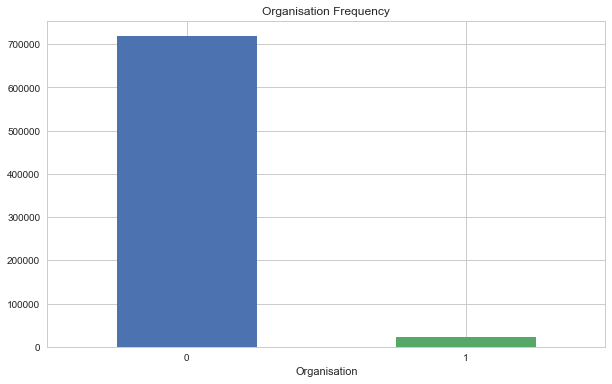

In [10]:
print(df.groupby('organisation').text.count()) 
fig = plt.figure(figsize=(10,6))
df.groupby('organisation').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.xlabel('Organisation')
plt.title('Organisation Frequency')
plt.show()
fig.savefig('Organisation Frequency.jpg', bbox_inches='tight')

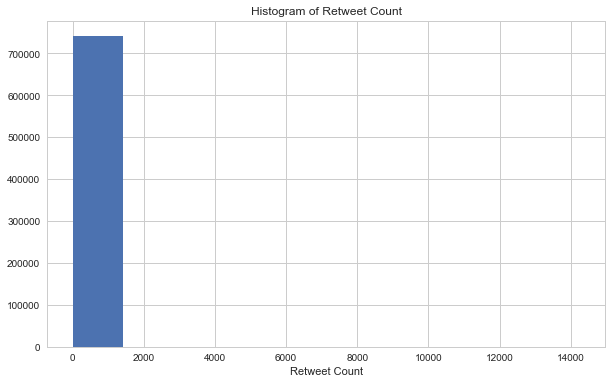

In [11]:
fig = plt.figure(figsize=(10,6))
df.rt_count.hist()
plt.title('Histogram of Retweet Count')
plt.xlabel('Retweet Count');
fig.savefig('Histogram of Retweet Count.jpg', bbox_inches='tight')

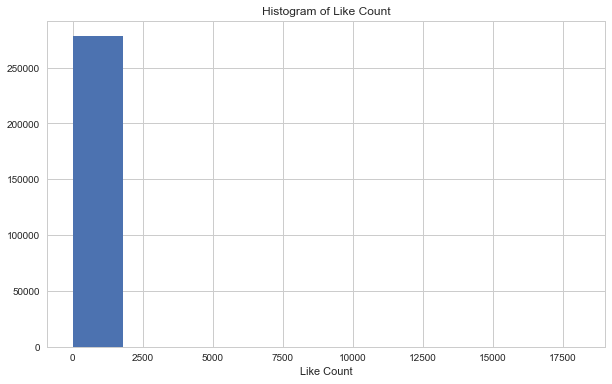

In [12]:
fig = plt.figure(figsize=(10,6))
df.like_count.hist()
plt.title('Histogram of Like Count')
plt.xlabel('Like Count');
fig.savefig('Histogram of Like Count.jpg', bbox_inches='tight')

rt_count_binary
0    463268
1    278143
Name: text, dtype: int64


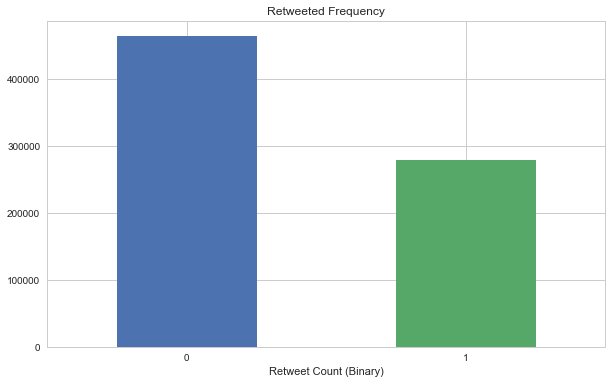

In [13]:
print(df.groupby('rt_count_binary').text.count())
fig = plt.figure(figsize=(10,6))
df.groupby('rt_count_binary').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.xlabel('Retweet Count (Binary)')
plt.title('Retweeted Frequency')
fig.savefig('Retweeted Frequency.jpg', bbox_inches='tight')

like_count_binary
0    559647
1    181764
Name: text, dtype: int64


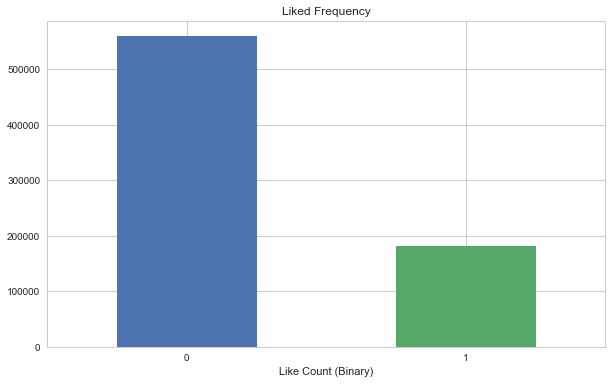

In [14]:
print(df.groupby('like_count_binary').text.count())
fig = plt.figure(figsize=(10,6))
df.groupby('like_count_binary').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.xlabel('Like Count (Binary)')
plt.title('Liked Frequency')
fig.savefig('Liked Frequency.jpg', bbox_inches='tight')

user_verified
False    726590
True     14821 
Name: text, dtype: int64


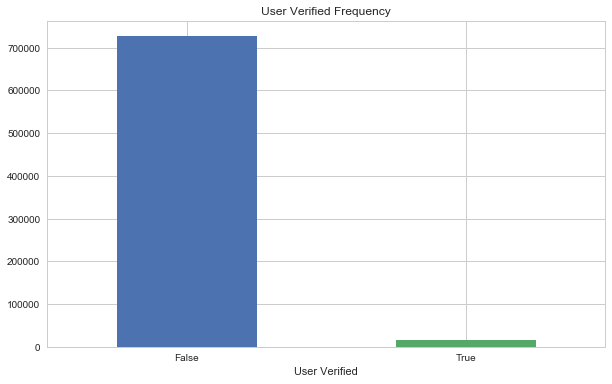

In [15]:
print(df.groupby('user_verified').text.count())
fig = plt.figure(figsize=(10,6))
df.groupby('user_verified').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.xlabel('User Verified')
plt.title('User Verified Frequency')
fig.savefig('User Verified Frequency.jpg', bbox_inches='tight')

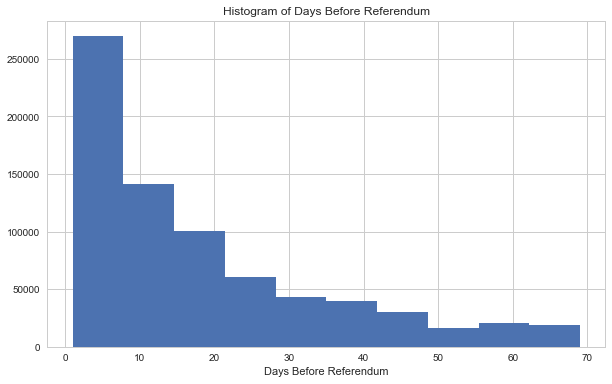

In [16]:
fig = plt.figure(figsize=(10,6))
df.days_before_ref.hist()
plt.title('Histogram of Days Before Referendum')
plt.xlabel('Days Before Referendum');
fig.savefig('Histogram of Days Before Referendum.jpg', bbox_inches='tight')

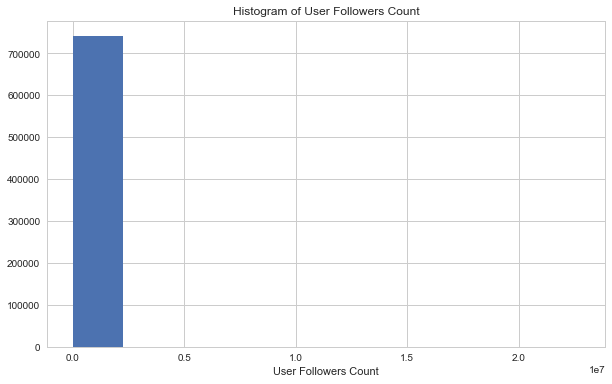

In [17]:
fig = plt.figure(figsize=(10,6))
df.user_followers_count.hist()
plt.title('Histogram of User Followers Count')
plt.xlabel('User Followers Count');
fig.savefig('Histogram of User Followers Count.jpg', bbox_inches='tight')

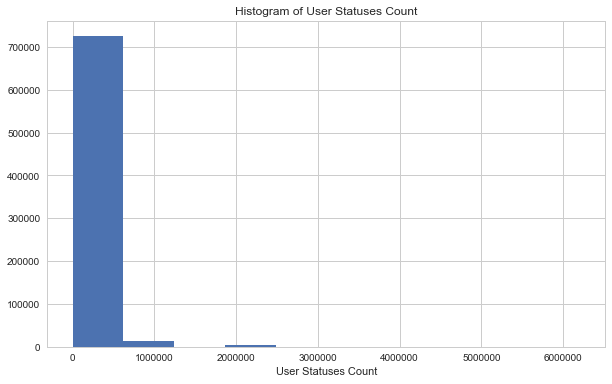

In [18]:
fig = plt.figure(figsize=(10,6))
df.user_statuses_count.hist()
plt.title('Histogram of User Statuses Count')
plt.xlabel('User Statuses Count');
fig.savefig('Histogram of User Statuses Count.jpg', bbox_inches='tight')

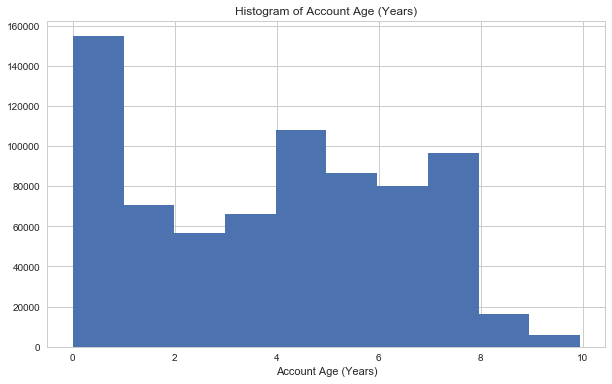

In [19]:
fig = plt.figure(figsize=(10,6))
df.account_age.hist()
plt.title('Histogram of Account Age (Years)')
plt.xlabel('Account Age (Years)');
fig.savefig('Histogram of Account Age.jpg', bbox_inches='tight')

day
Friday       71595 
Monday       100237
Saturday     70670 
Sunday       81527 
Thursday     92321 
Tuesday      153516
Wednesday    171545
Name: text, dtype: int64


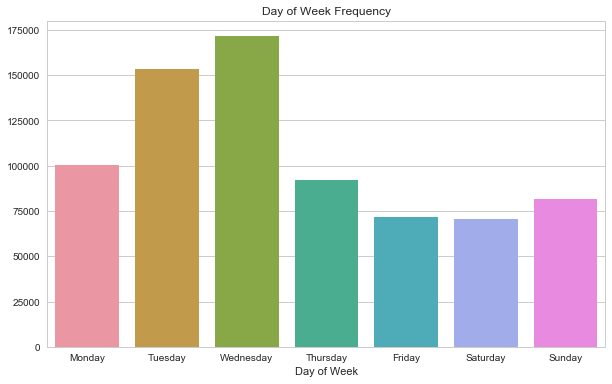

In [20]:
print(df.groupby('day').text.count())
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='day', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(figsize=(10,6))
plt.title('Day of Week Frequency')
plt.ylabel('')
plt.xlabel('Day of Week');
fig.savefig('Day of Week Frequency.jpg', bbox_inches='tight')

hour_binned
Afternoon      220236
Morning        189029
Night          303474
Small hours    28672 
Name: text, dtype: int64


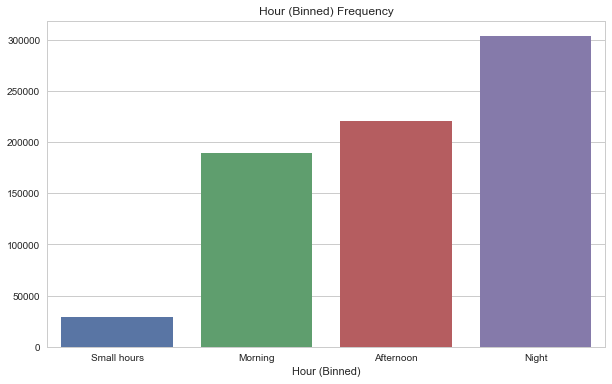

In [21]:
print(df.groupby('hour_binned').text.count())
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='hour_binned', order=['Small hours', 'Morning', 'Afternoon', 'Night']).plot(figsize=(10,6))
plt.title('Hour (Binned) Frequency')
plt.ylabel('')
plt.xlabel('Hour (Binned)');
fig.savefig('Hour (Binned) Frequency.jpg', bbox_inches='tight')

hashtags_count
1.00     228107
2.00     222643
3.00     127588
4.00     78235 
5.00     34508 
6.00     27982 
7.00     9952  
8.00     5024  
9.00     3222  
10.00    1749  
11.00    762   
12.00    409   
13.00    204   
14.00    102   
15.00    907   
16.00    8     
17.00    5     
18.00    2     
20.00    1     
21.00    1     
Name: text, dtype: int64


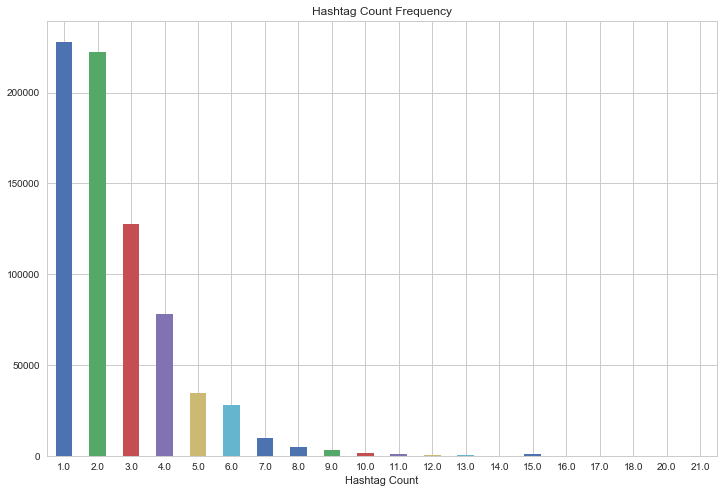

In [22]:
print(df.groupby('hashtags_count').text.count())
fig = plt.figure(figsize=(12,8))
df.groupby('hashtags_count').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.title('Hashtag Count Frequency')
plt.xlabel('Hashtag Count');
fig.savefig('Hashtag Count Frequency.jpg', bbox_inches='tight')

mentions_count
0.00     580350
1.00     121938
2.00     27442 
3.00     7780  
4.00     2567  
5.00     917   
6.00     303   
7.00     89    
8.00     20    
9.00     2     
10.00    3     
Name: text, dtype: int64


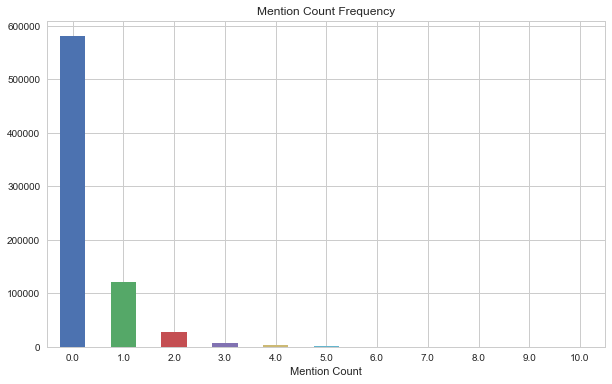

In [23]:
print(df.groupby('mentions_count').text.count())
fig = plt.figure(figsize=(10,6))
df.groupby('mentions_count').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.title('Mention Count Frequency')
plt.xlabel('Mention Count');
fig.savefig('Mention Count Frequency.jpg', bbox_inches='tight')

urls_count
0.00    488574
1.00    249921
2.00    2847  
3.00    58    
4.00    11    
Name: text, dtype: int64
urls_count_binary
0    488574
1    252837
Name: text, dtype: int64


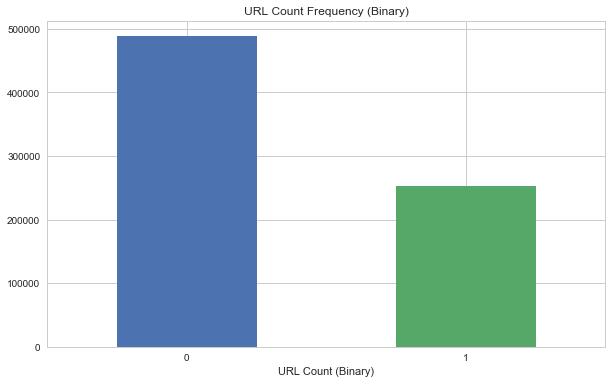

In [24]:
print(df.groupby('urls_count').text.count())
print(df.groupby('urls_count_binary').text.count())
fig = plt.figure(figsize=(10,6))
df.groupby('urls_count_binary').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.title('URL Count Frequency (Binary)')
plt.xlabel('URL Count (Binary)');
fig.savefig('URL Count Frequency (Binary).jpg', bbox_inches='tight')

media_type_count
0.00    571490
1.00    160231
2.00    5174  
3.00    1792  
4.00    2724  
Name: text, dtype: int64
media_type_count_binary
0    571490
1    169921
Name: text, dtype: int64


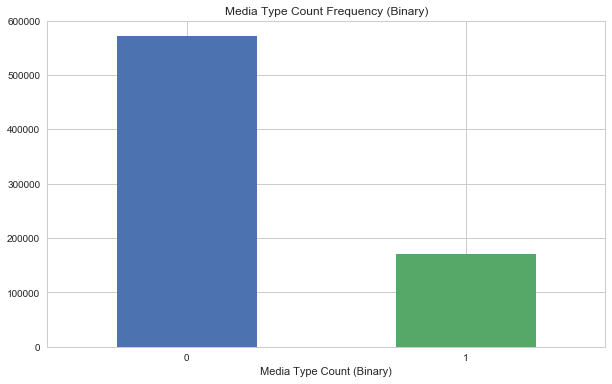

In [25]:
print(df.groupby('media_type_count').text.count())
print(df.groupby('media_type_count_binary').text.count())
fig = plt.figure(figsize=(10,6))
df.groupby('media_type_count_binary').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.title('Media Type Count Frequency (Binary)')
plt.xlabel('Media Type Count (Binary)');
fig.savefig('Media Type Count Frequency (Binary).jpg', bbox_inches='tight')

photo
0    578089
1    163322
Name: text, dtype: int64


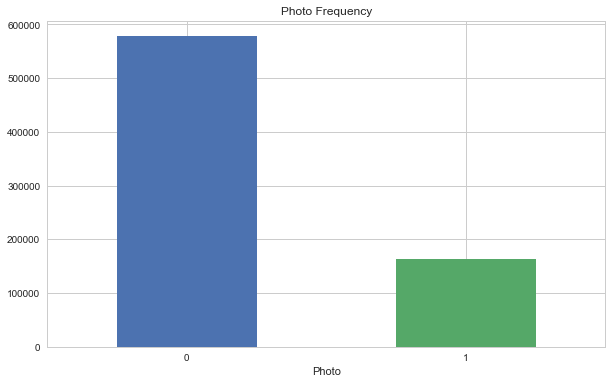

In [26]:
print(df.groupby('photo').text.count())
fig = plt.figure(figsize=(10,6))
df.groupby('photo').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.title('Photo Frequency')
plt.xlabel('Photo');
fig.savefig('Photo Frequency.jpg', bbox_inches='tight')

video
0    737598
1    3813  
Name: text, dtype: int64


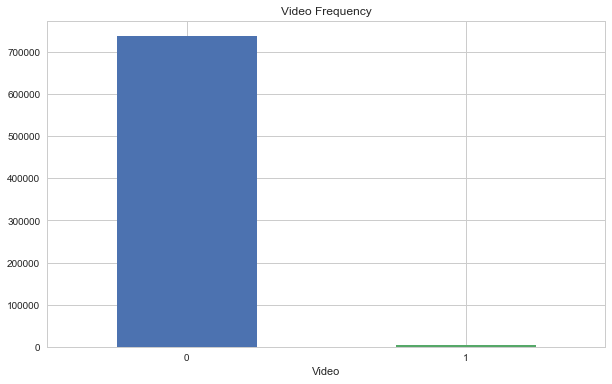

In [27]:
print(df.groupby('video').text.count())
fig = plt.figure(figsize=(10,6))
df.groupby('video').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.title('Video Frequency')
plt.xlabel('Video');
fig.savefig('Video Frequency.jpg', bbox_inches='tight')

gif
0    738617
1    2794  
Name: text, dtype: int64


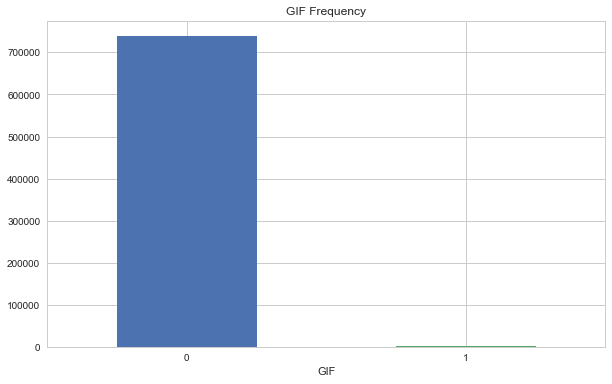

In [28]:
print(df.groupby('gif').text.count())
fig = plt.figure(figsize=(10,6))
df.groupby('gif').text.count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.title('GIF Frequency')
plt.xlabel('GIF');
fig.savefig('GIF Frequency.jpg', bbox_inches='tight')

### Visualise Crosstabulations of Categorical IVs with DVs

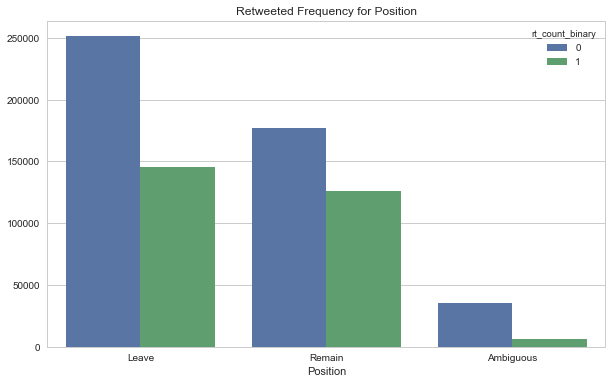

In [29]:
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='position', hue='rt_count_binary', order=['Leave', 'Remain', 'Ambiguous']).plot(figsize=(10,6))
plt.title('Retweeted Frequency for Position')
plt.ylabel('')
plt.xlabel('Position')
plt.savefig('Retweeted Frequency for Position', bbox_inches='tight')

position
Ambiguous   0.90
Leave       4.91
Remain      3.76
Name: rt_count, dtype: float64


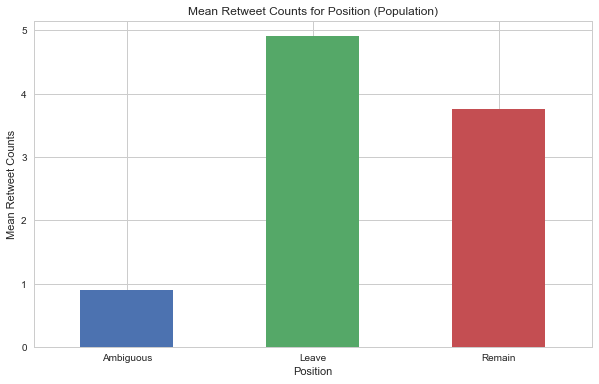

In [5]:
grouped_position = df.groupby('position')
print(grouped_position['rt_count'].agg(np.mean))
grouped_position['rt_count'].agg(np.mean).plot(kind='bar', figsize=(10,6), legend=False)
plt.title('Mean Retweet Counts for Position (Population)')
plt.ylabel('Mean Retweet Counts')
plt.xlabel('Position')
plt.xticks(rotation='horizontal')
plt.savefig('Mean Retweet Counts for Position.jpg', bbox_inches='tight')

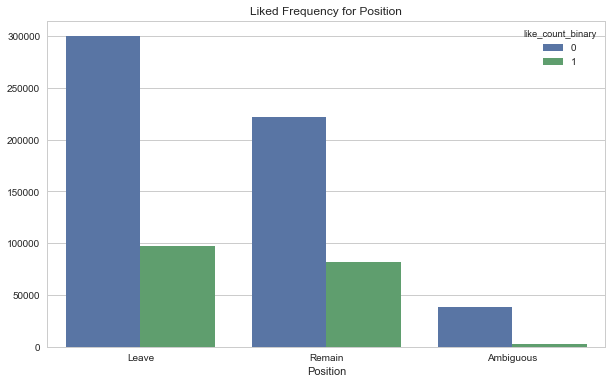

In [30]:
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='position', hue='like_count_binary', order=['Leave', 'Remain', 'Ambiguous']).plot(figsize=(10,6))
plt.title('Liked Frequency for Position')
plt.ylabel('')
plt.xlabel('Position')
plt.savefig('Liked Frequency for Position', bbox_inches='tight')

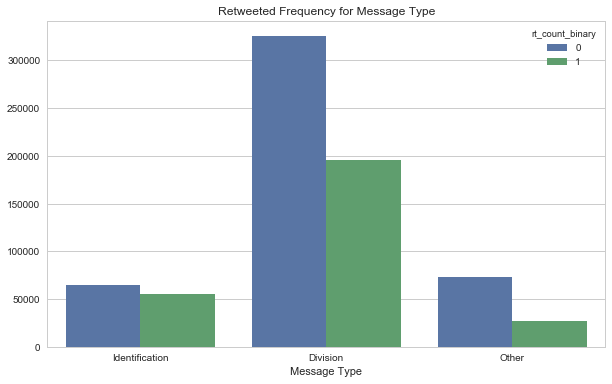

In [31]:
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='message_type', hue='rt_count_binary', order=['Identification', 'Division', 'Other']).plot(figsize=(10,6))
plt.title('Retweeted Frequency for Message Type')
plt.ylabel('')
plt.xlabel('Message Type')
plt.savefig('Retweeted Frequency for Message Type', bbox_inches='tight')

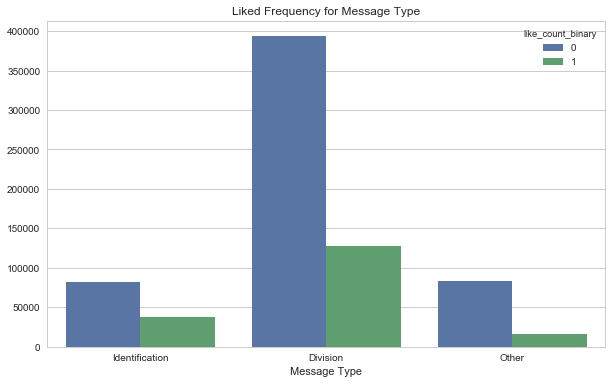

In [32]:
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='message_type', hue='like_count_binary', order=['Identification', 'Division', 'Other']).plot(figsize=(10,6))
plt.title('Liked Frequency for Message Type')
plt.ylabel('')
plt.xlabel('Message Type')
plt.savefig('Liked Frequency for Message Type', bbox_inches='tight')

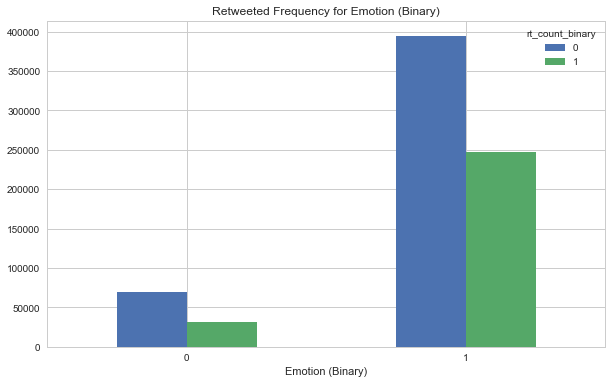

In [33]:
pd.crosstab(df.emotion, df.rt_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Retweeted Frequency for Emotion (Binary)')
plt.xticks(rotation='horizontal')
plt.xlabel('Emotion (Binary)');
plt.savefig('Retweeted Frequency for Emotion (Binary)', bbox_inches='tight')

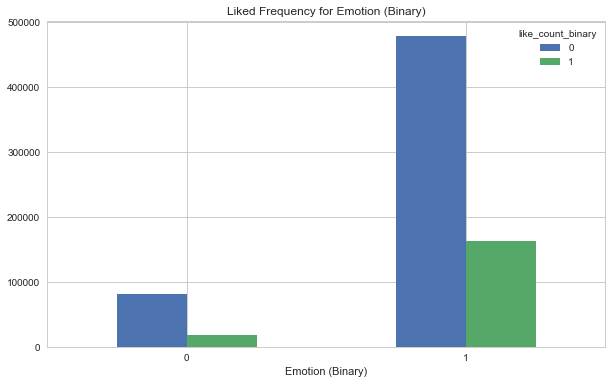

In [34]:
pd.crosstab(df.emotion, df.like_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Liked Frequency for Emotion (Binary)')
plt.xticks(rotation='horizontal')
plt.xlabel('Emotion (Binary)');
plt.savefig('Liked Frequency for Emotion (Binary)', bbox_inches='tight')

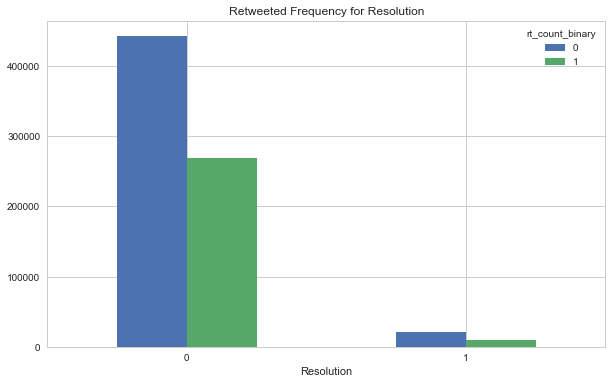

In [35]:
pd.crosstab(df.resolution, df.rt_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Retweeted Frequency for Resolution')
plt.xticks(rotation='horizontal')
plt.xlabel('Resolution');
plt.savefig('Retweeted Frequency for Resolution', bbox_inches='tight')

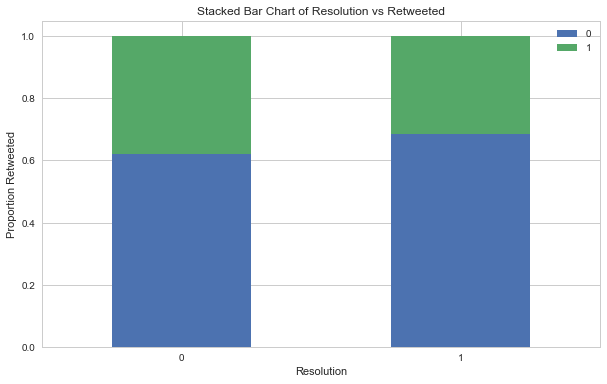

In [36]:
table = pd.crosstab(df.resolution, df.rt_count_binary)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Stacked Bar Chart of Resolution vs Retweeted')
plt.legend(loc='upper right')
plt.xticks(rotation='horizontal')
plt.xlabel('Resolution')
plt.ylabel('Proportion Retweeted');
plt.savefig('Stacked Bar Chart of Resolution vs Retweeted', bbox_inches='tight')

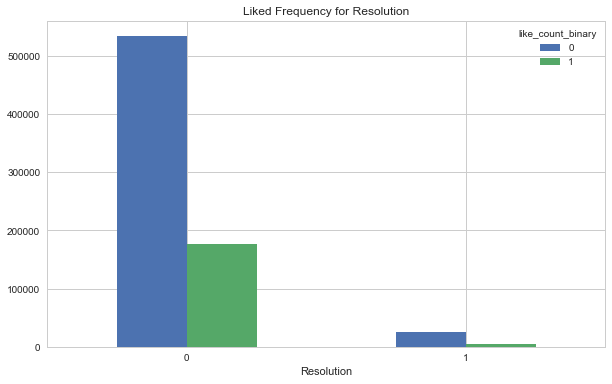

In [37]:
pd.crosstab(df.resolution, df.like_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Liked Frequency for Resolution')
plt.xticks(rotation='horizontal')
plt.xlabel('Resolution');
plt.savefig('Liked Frequency for Resolution', bbox_inches='tight')

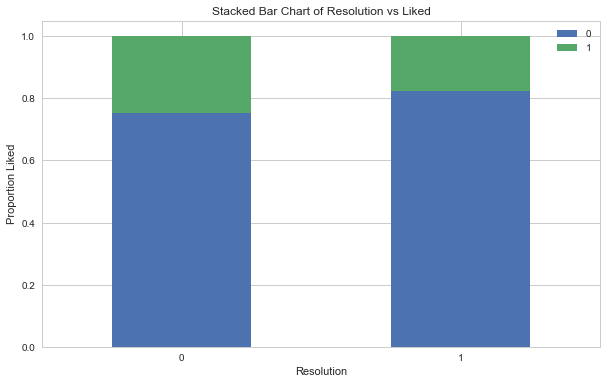

In [38]:
table = pd.crosstab(df.resolution, df.like_count_binary)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Stacked Bar Chart of Resolution vs Liked')
plt.legend(loc='upper right')
plt.xticks(rotation='horizontal')
plt.xlabel('Resolution')
plt.ylabel('Proportion Liked');
plt.savefig('Stacked Bar Chart of Resolution vs Liked', bbox_inches='tight')

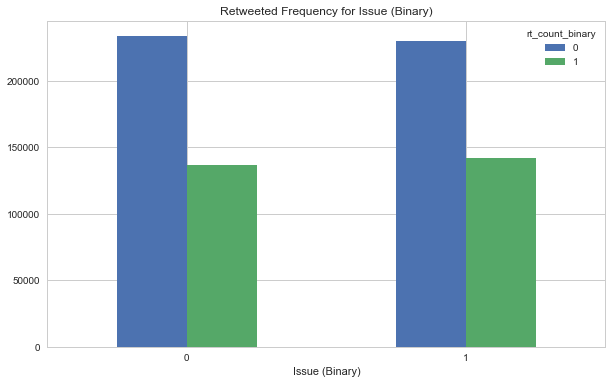

In [39]:
pd.crosstab(df.issue, df.rt_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Retweeted Frequency for Issue (Binary)')
plt.xticks(rotation='horizontal')
plt.xlabel('Issue (Binary)');
plt.savefig('Retweeted Frequency for Issue (Binary)', bbox_inches='tight')

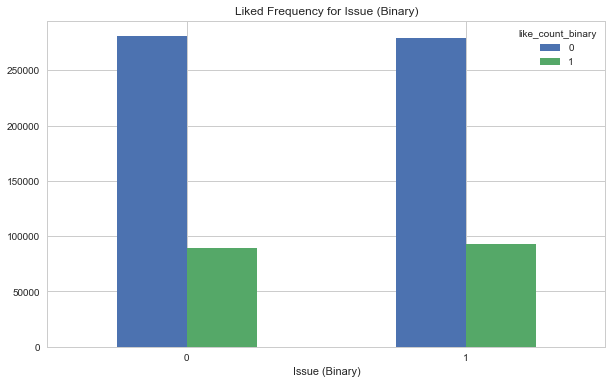

In [40]:
pd.crosstab(df.issue, df.like_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Liked Frequency for Issue (Binary)')
plt.xticks(rotation='horizontal')
plt.xlabel('Issue (Binary)');
plt.savefig('Liked Frequency for Issue (Binary)', bbox_inches='tight')

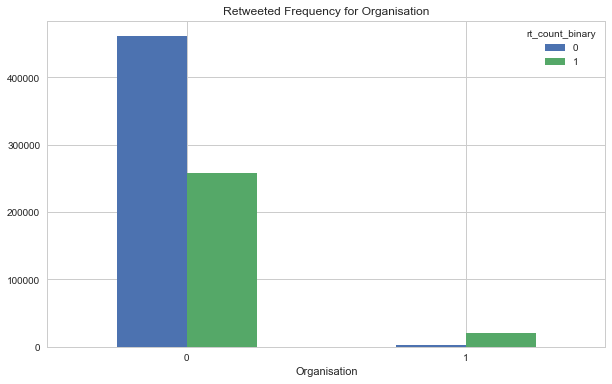

In [41]:
pd.crosstab(df.organisation, df.rt_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Retweeted Frequency for Organisation')
plt.xticks(rotation='horizontal')
plt.xlabel('Organisation');
plt.savefig('Retweeted Frequency for Organisation', bbox_inches='tight')

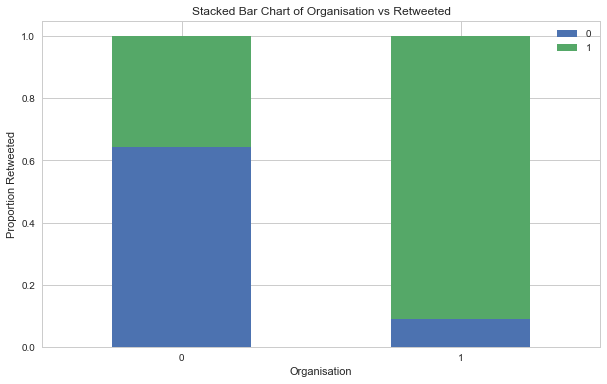

In [42]:
table = pd.crosstab(df.organisation, df.rt_count_binary)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Stacked Bar Chart of Organisation vs Retweeted')
plt.legend(loc='upper right')
plt.xticks(rotation='horizontal')
plt.xlabel('Organisation')
plt.ylabel('Proportion Retweeted');
plt.savefig('Stacked Bar Chart of Organisation vs Retweeted', bbox_inches='tight')

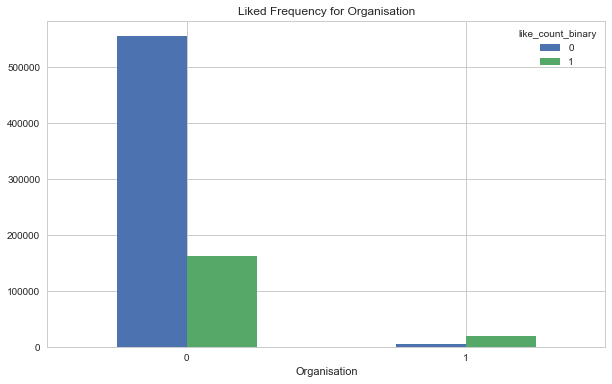

In [43]:
pd.crosstab(df.organisation, df.like_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Liked Frequency for Organisation')
plt.xticks(rotation='horizontal')
plt.xlabel('Organisation');
plt.savefig('Liked Frequency for Organisation', bbox_inches='tight')

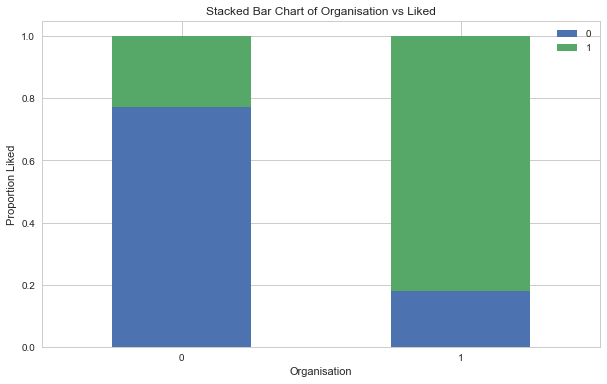

In [44]:
table = pd.crosstab(df.organisation, df.like_count_binary)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Stacked Bar Chart of Organisation vs Liked')
plt.legend(loc='upper right')
plt.xticks(rotation='horizontal')
plt.xlabel('Organisation')
plt.ylabel('Proportion Liked');
plt.savefig('Stacked Bar Chart of Organisation vs Liked', bbox_inches='tight')

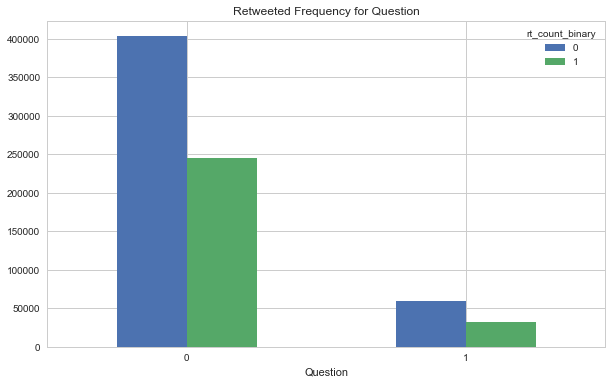

In [45]:
pd.crosstab(df.question, df.rt_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Retweeted Frequency for Question')
plt.xticks(rotation='horizontal')
plt.xlabel('Question');
plt.savefig('Retweeted Frequency for Question', bbox_inches='tight')

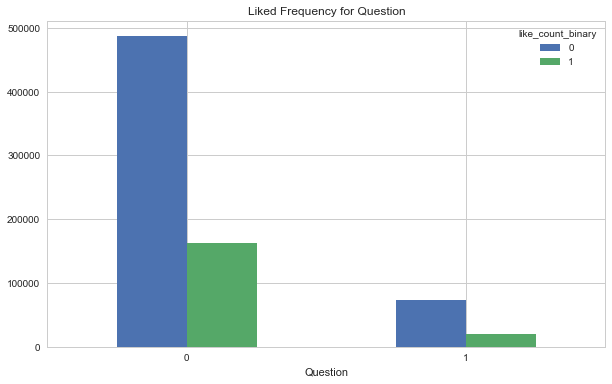

In [46]:
pd.crosstab(df.question, df.like_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Liked Frequency for Question')
plt.xticks(rotation='horizontal')
plt.xlabel('Question');
plt.savefig('Liked Frequency for Question', bbox_inches='tight')

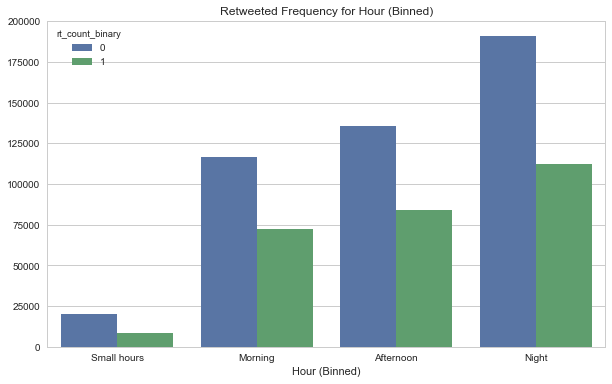

In [47]:
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='hour_binned', hue='rt_count_binary', order=['Small hours', 'Morning', 'Afternoon', 'Night']).plot(figsize=(10,6))
plt.title('Retweeted Frequency for Hour (Binned)')
plt.ylabel('')
plt.xlabel('Hour (Binned)')
plt.savefig('Retweeted Frequency for Hour (Binned)', bbox_inches='tight')

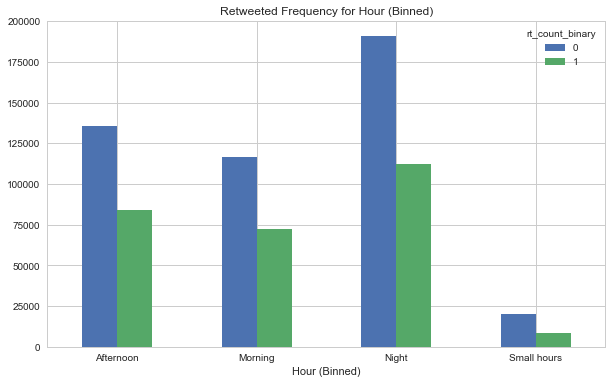

In [48]:
# Same as countplot above, only columns are skinner and not in a meaningful order.
pd.crosstab(df.hour_binned, df.rt_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Retweeted Frequency for Hour (Binned)')
plt.xticks(rotation='horizontal')
plt.xlabel('Hour (Binned)');
#plt.savefig('Retweeted Frequency for Hour (Binned)', bbox_inches='tight')

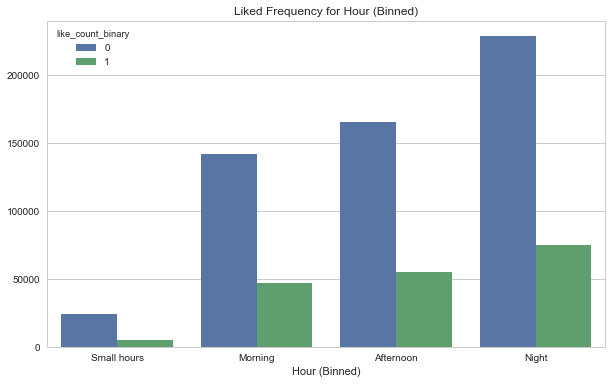

In [49]:
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='hour_binned', hue='like_count_binary', order=['Small hours', 'Morning', 'Afternoon', 'Night']).plot(figsize=(10,6))
plt.title('Liked Frequency for Hour (Binned)')
plt.ylabel('')
plt.xlabel('Hour (Binned)')
plt.savefig('Liked Frequency for Hour (Binned)', bbox_inches='tight')

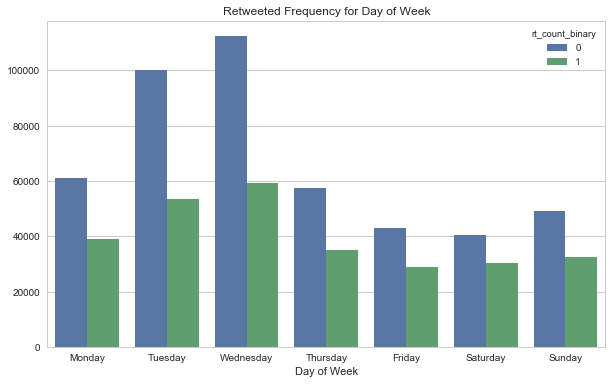

In [50]:
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='day', hue='rt_count_binary', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(figsize=(10,6))
plt.title('Retweeted Frequency for Day of Week')
plt.ylabel('')
plt.xlabel('Day of Week');
plt.savefig('Retweeted Frequency for Day of Week', bbox_inches='tight')

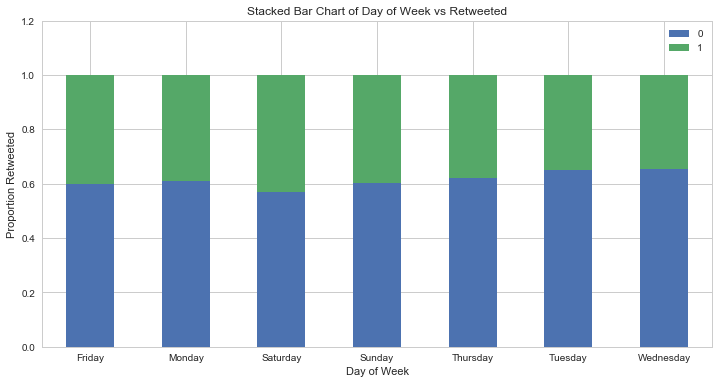

In [21]:
table = pd.crosstab(df.day, df.rt_count_binary)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Stacked Bar Chart of Day of Week vs Retweeted')
plt.legend(loc='upper right')
plt.xticks(rotation='horizontal')
plt.xlabel('Day of Week')
plt.ylabel('Proportion Retweeted')
plt.ylim([0,1.2])
plt.savefig('Stacked Bar Chart of Day of Week vs Retweeted', bbox_inches='tight')

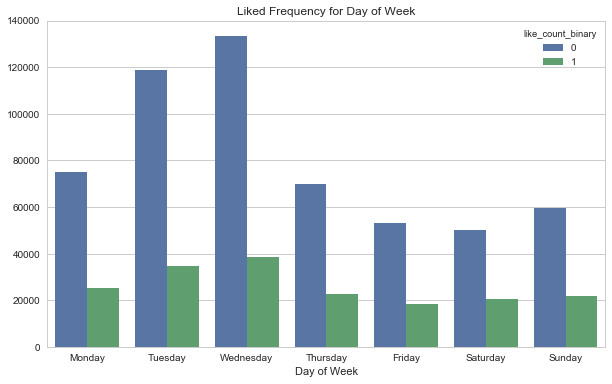

In [51]:
fig = plt.figure(figsize=(10,6))
sns.countplot(data=df, x='day', hue='like_count_binary', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).plot(figsize=(10,6))
plt.title('Liked Frequency for Day of Week')
plt.ylabel('')
plt.xlabel('Day of Week');
plt.savefig('Liked Frequency for Day of Week', bbox_inches='tight')

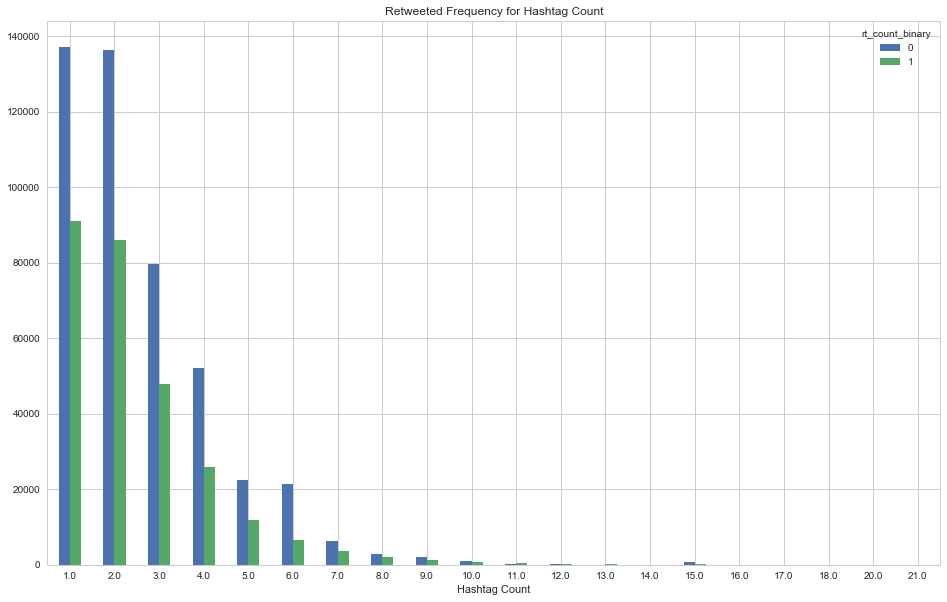

In [52]:
pd.crosstab(df.hashtags_count, df.rt_count_binary).plot(kind='bar', figsize=(16,10))
plt.title('Retweeted Frequency for Hashtag Count')
plt.xticks(rotation='horizontal')
plt.xlabel('Hashtag Count');
plt.savefig('Retweeted Frequency for Hashtag Count', bbox_inches='tight')

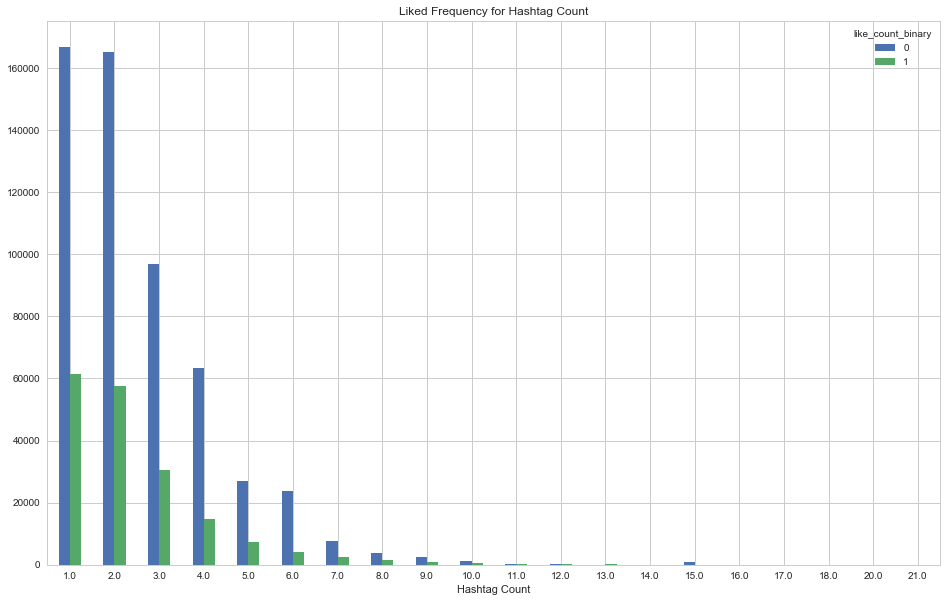

In [53]:
pd.crosstab(df.hashtags_count, df.like_count_binary).plot(kind='bar', figsize=(16,10))
plt.title('Liked Frequency for Hashtag Count')
plt.xticks(rotation='horizontal')
plt.xlabel('Hashtag Count');
plt.savefig('Liked Frequency for Hashtag Count', bbox_inches='tight')

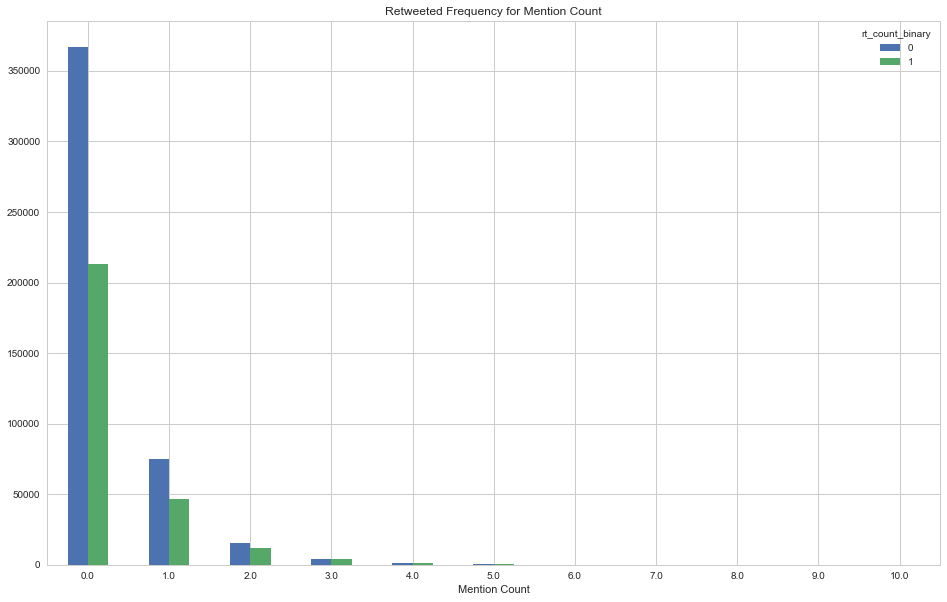

In [54]:
pd.crosstab(df.mentions_count, df.rt_count_binary).plot(kind='bar', figsize=(16,10))
plt.title('Retweeted Frequency for Mention Count')
plt.xticks(rotation='horizontal')
plt.xlabel('Mention Count');
plt.savefig('Retweeted Frequency for Mention Count', bbox_inches='tight')

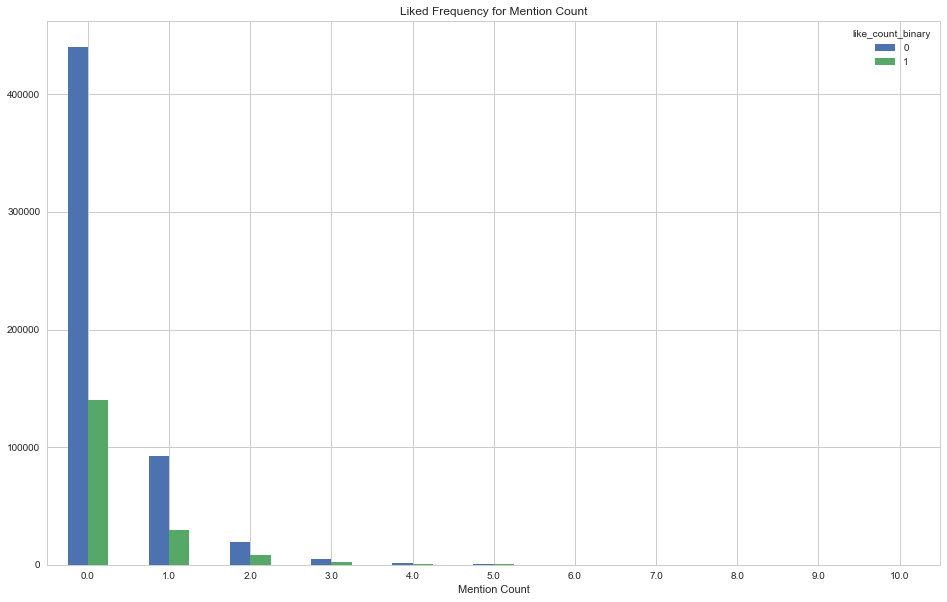

In [55]:
pd.crosstab(df.mentions_count, df.like_count_binary).plot(kind='bar', figsize=(16,10))
plt.title('Liked Frequency for Mention Count')
plt.xticks(rotation='horizontal')
plt.xlabel('Mention Count');
plt.savefig('Liked Frequency for Mention Count', bbox_inches='tight')

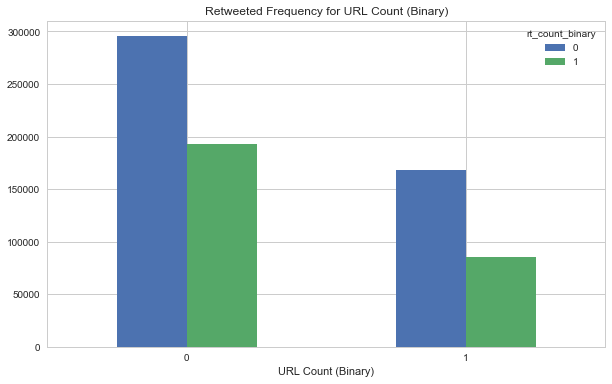

In [56]:
pd.crosstab(df.urls_count_binary, df.rt_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Retweeted Frequency for URL Count (Binary)')
plt.xticks(rotation='horizontal')
plt.xlabel('URL Count (Binary)');
plt.savefig('Retweeted Frequency for URL Count (Binary)', bbox_inches='tight')

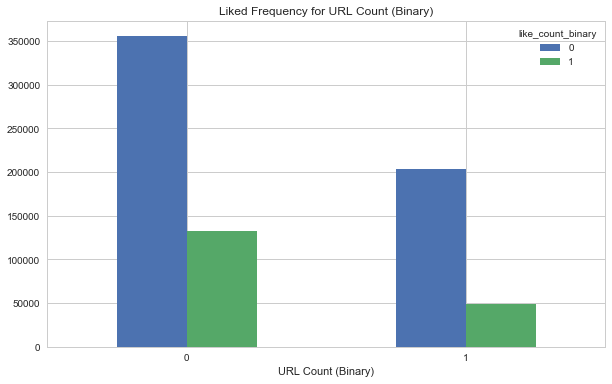

In [57]:
pd.crosstab(df.urls_count_binary, df.like_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Liked Frequency for URL Count (Binary)')
plt.xticks(rotation='horizontal')
plt.xlabel('URL Count (Binary)');
plt.savefig('Liked Frequency for URL Count (Binary)', bbox_inches='tight')

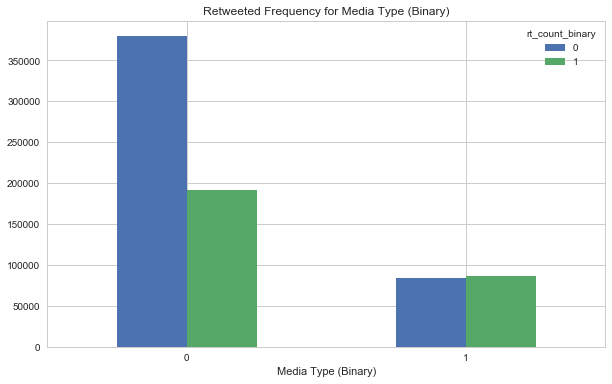

In [58]:
pd.crosstab(df.media_type_count_binary, df.rt_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Retweeted Frequency for Media Type (Binary)')
plt.xticks(rotation='horizontal')
plt.xlabel('Media Type (Binary)');
plt.savefig('Retweeted Frequency for Media Type (Binary)', bbox_inches='tight')

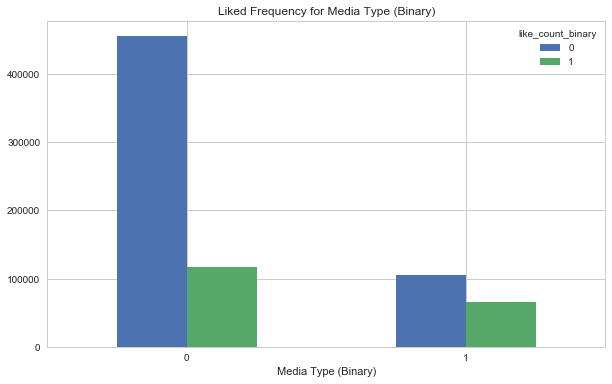

In [59]:
pd.crosstab(df.media_type_count_binary, df.like_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Liked Frequency for Media Type (Binary)')
plt.xticks(rotation='horizontal')
plt.xlabel('Media Type (Binary)');
plt.savefig('Liked Frequency for Media Type (Binary)', bbox_inches='tight')

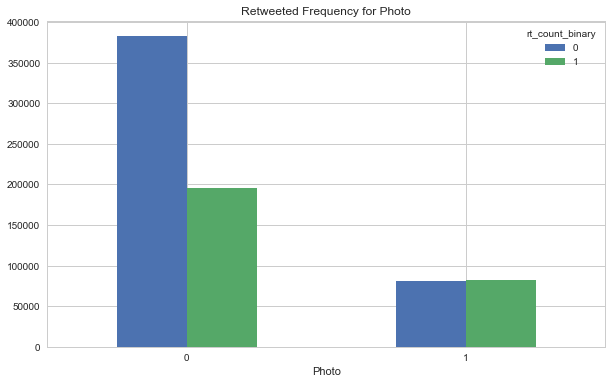

In [60]:
pd.crosstab(df.photo, df.rt_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Retweeted Frequency for Photo')
plt.xticks(rotation='horizontal')
plt.xlabel('Photo');
plt.savefig('Retweeted Frequency for Photo', bbox_inches='tight')

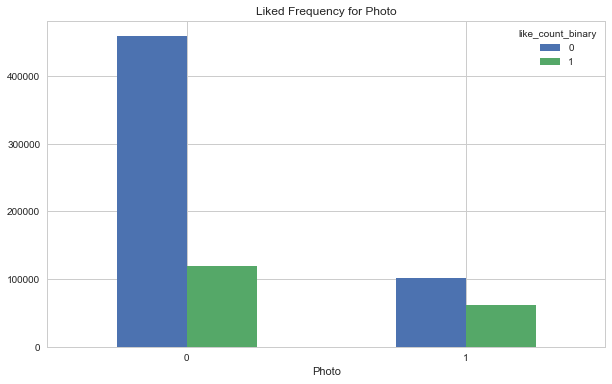

In [61]:
pd.crosstab(df.photo, df.like_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Liked Frequency for Photo')
plt.xticks(rotation='horizontal')
plt.xlabel('Photo');
plt.savefig('Liked Frequency for Photo', bbox_inches='tight')

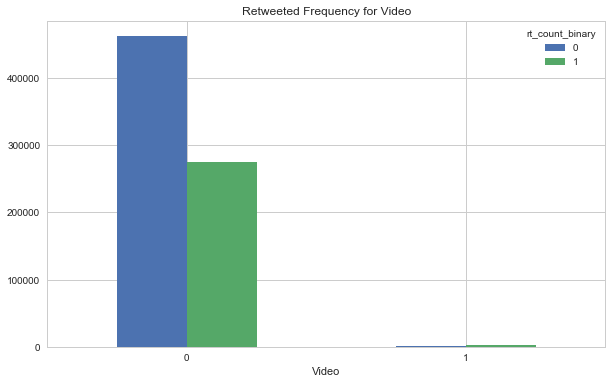

In [62]:
pd.crosstab(df.video, df.rt_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Retweeted Frequency for Video')
plt.xticks(rotation='horizontal')
plt.xlabel('Video');
plt.savefig('Retweeted Frequency for Video', bbox_inches='tight')

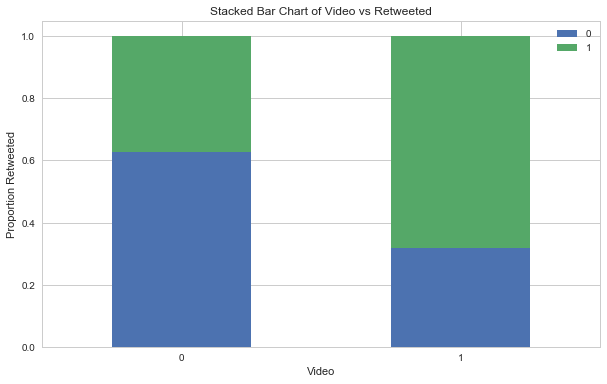

In [63]:
table = pd.crosstab(df.video, df.rt_count_binary)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Stacked Bar Chart of Video vs Retweeted')
plt.legend(loc='upper right')
plt.xticks(rotation='horizontal')
plt.xlabel('Video')
plt.ylabel('Proportion Retweeted');
plt.savefig('Stacked Bar Chart of Video vs Retweeted', bbox_inches='tight')

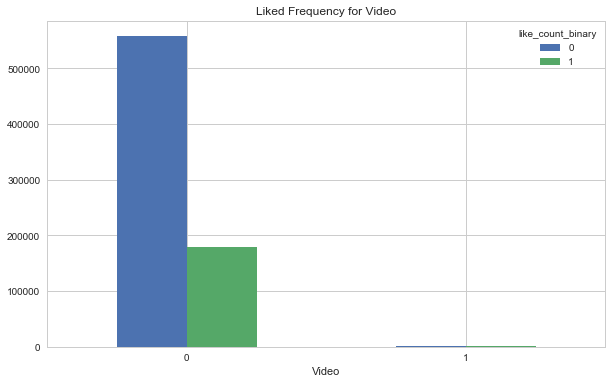

In [64]:
pd.crosstab(df.video, df.like_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Liked Frequency for Video')
plt.xticks(rotation='horizontal')
plt.xlabel('Video');
plt.savefig('Liked Frequency for Video', bbox_inches='tight')

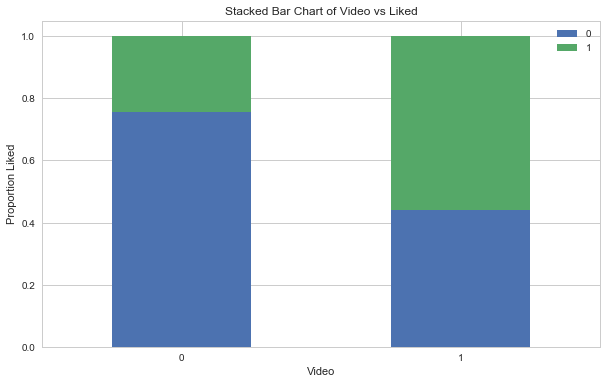

In [65]:
table = pd.crosstab(df.video, df.like_count_binary)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Stacked Bar Chart of Video vs Liked')
plt.legend(loc='upper right')
plt.xticks(rotation='horizontal')
plt.xlabel('Video')
plt.ylabel('Proportion Liked');
plt.savefig('Stacked Bar Chart of Video vs Liked', bbox_inches='tight')

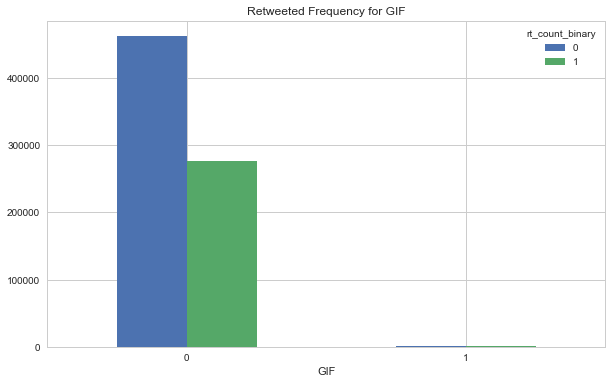

In [66]:
pd.crosstab(df.gif, df.rt_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Retweeted Frequency for GIF')
plt.xticks(rotation='horizontal')
plt.xlabel('GIF');
plt.savefig('Retweeted Frequency for GIF', bbox_inches='tight')

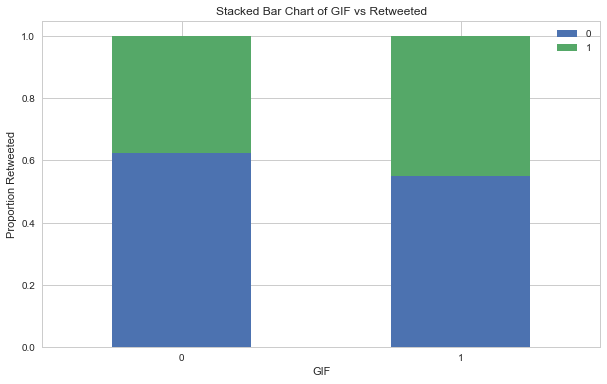

In [67]:
table = pd.crosstab(df.gif, df.rt_count_binary)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Stacked Bar Chart of GIF vs Retweeted')
plt.legend(loc='upper right')
plt.xticks(rotation='horizontal')
plt.xlabel('GIF')
plt.ylabel('Proportion Retweeted');
plt.savefig('Stacked Bar Chart of GIF vs Retweeted', bbox_inches='tight')

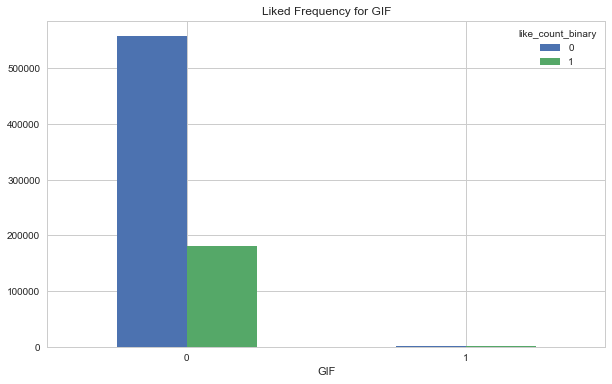

In [68]:
pd.crosstab(df.gif, df.like_count_binary).plot(kind='bar', figsize=(10,6))
plt.title('Liked Frequency for GIF')
plt.xticks(rotation='horizontal')
plt.xlabel('GIF');
plt.savefig('Liked Frequency for GIF', bbox_inches='tight')

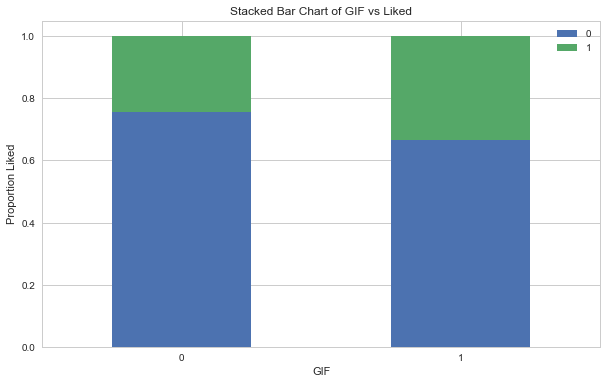

In [69]:
table = pd.crosstab(df.gif, df.like_count_binary)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Stacked Bar Chart of GIF vs Liked')
plt.legend(loc='upper right')
plt.xticks(rotation='horizontal')
plt.xlabel('GIF')
plt.ylabel('Proportion Liked');
plt.savefig('Stacked Bar Chart of GIF vs Liked', bbox_inches='tight')

In [70]:
'''
Log-transforming skewed IVs
df.insert(8, 'days_before_ref_log10', np.log10(df.days_before_ref))
df.insert(29, 'user_statuses_count_log10', np.log10(df.user_statuses_count))
df.insert(23, 'user_followers_count_log10', np.log10(df.user_followers_count+1)) # Need to add one because the log of 0 is -inf.
sample_df.insert(8, 'days_before_ref_log10', np.log10(sample_df.days_before_ref))
sample_df.insert(20, 'user_followers_count_log10', np.log10(sample_df.user_followers_count+1)) # Need to add one because the log of 0 is -inf.
sample_df.insert(26, 'user_statuses_count_log10', np.log10(sample_df.user_statuses_count))
'''

"\nLog-transforming skewed IVs\ndf.insert(8, 'days_before_ref_log10', np.log10(df.days_before_ref))\ndf.insert(29, 'user_statuses_count_log10', np.log10(df.user_statuses_count))\ndf.insert(23, 'user_followers_count_log10', np.log10(df.user_followers_count+1)) # Need to add one because the log of 0 is -inf.\nsample_df.insert(8, 'days_before_ref_log10', np.log10(sample_df.days_before_ref))\nsample_df.insert(20, 'user_followers_count_log10', np.log10(sample_df.user_followers_count+1)) # Need to add one because the log of 0 is -inf.\nsample_df.insert(26, 'user_statuses_count_log10', np.log10(sample_df.user_statuses_count))\n"